# Exercise 1

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# 1
df_train = pd.read_csv("train.tsv", sep="\t")
df_test = pd.read_csv("test.tsv", sep="\t")

In [3]:
print(f"Train dataset size before cleaning :{df_train.shape[0]}")
print(f"Test dataset size before clearning :{df_test.shape[0]}")

Train dataset size before cleaning :70000
Test dataset size before clearning :20000


In [4]:
def data_cleaning(df):
    df_cleaned = df.sort_values(["user_id", "item_id", "time"],ascending=[True,True, True])
    df_cleaned = df_cleaned.dropna(subset=["user_id", "item_id", "time"])
    df_cleaned = df_cleaned.drop_duplicates(keep="last", subset=["user_id", "item_id"])
    return df_cleaned

df_train = data_cleaning(df_train)
df_test = data_cleaning(df_test)

In [5]:
print(f"Training dataset after duplication and missing value removal {df_train.shape[0]}")
print(f"Test dataset after duplication and missing value removal {df_test.shape[0]}")

Training dataset after duplication and missing value removal 61008
Test dataset after duplication and missing value removal 14631


In [6]:
def make_test_data_consistent(df_test, users_in_training_dataset):
    # drop all test records for users that aren't present in the train dataset
    return df_test[df_test.user_id.isin(users_in_training_dataset)]

In [7]:
df_test = make_test_data_consistent(df_test, df_train.user_id.tolist())

In [8]:
print(f"Test dataset after user removal {df_test.shape[0]}")

Test dataset after user removal 14631


In [9]:
train_users = set(df_train.user_id.tolist())
test_users = set(df_test.user_id.tolist())

print(f"# users in the training dataset that aren't present in the test dataset: {len(train_users - test_users)}")
print(f"# users in the test dataset that aren't present in the training dataset: {len(test_users - train_users)}")

# users in the training dataset that aren't present in the test dataset: 153
# users in the test dataset that aren't present in the training dataset: 0


All users present in the test dataset are present in the training dataset. Hence, we won't try to evaluate the models based on how they handle the cold start problem

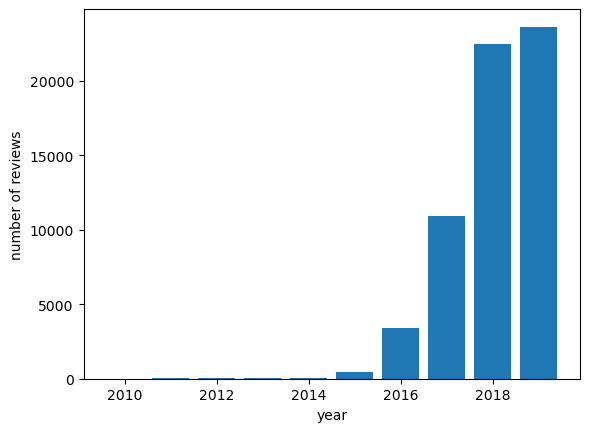

In [10]:
review_years_training_dataset = pd.to_datetime(df_train.time, unit='ms').dt.year
plt.bar(*np.unique(review_years_training_dataset, return_counts=True))
plt.xlabel("year")
plt.ylabel("number of reviews")
plt.show()

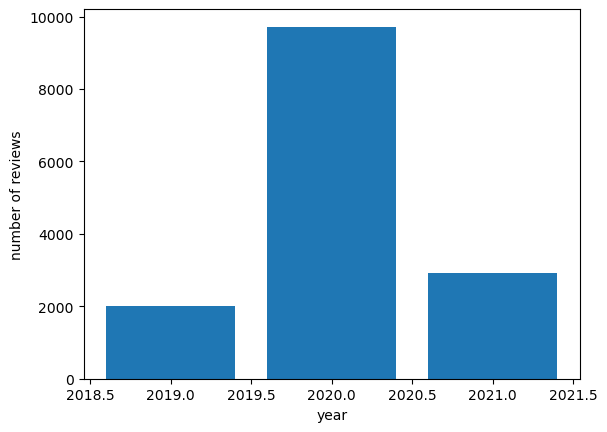

In [11]:
review_years_testing_dataset = pd.to_datetime(df_test.time, unit='ms').dt.year
plt.bar(*np.unique(review_years_testing_dataset, return_counts=True))
plt.xlabel("year")
plt.ylabel("number of reviews")
plt.show()

It seems that the whole dataset was split based on the timestamp. No leaks of future info in the dataset. If there were leakage, that would mean that the system would learn the user's behaviour based on their future behaviour in order to estimate their past behaviour. Also using temporal split improves the measurement of generalization of the model.

In [244]:
avg_item_rating_training_dataset = df_train[["item_id","rating"]].groupby("item_id", as_index=False).agg(avg_rating=("rating","mean"), count=("rating","size"))
avg_high_rated_item_training_dataset = avg_item_rating_training_dataset[avg_item_rating_training_dataset.avg_rating >= 3]
avg_high_rated_item_freq_training_dataset = avg_high_rated_item_training_dataset.shape[0]/avg_item_rating_training_dataset.shape[0]

avg_item_rating_test_dataset = df_test[["item_id","rating"]].groupby("item_id", as_index=False).agg(avg_rating=("rating","mean"), count=("rating","size"))
avg_high_rated_item_test_dataset = avg_item_rating_test_dataset[avg_item_rating_test_dataset.avg_rating >= 3]
avg_high_rated_item_freq_test_dataset = avg_high_rated_item_test_dataset.shape[0]/avg_item_rating_test_dataset.shape[0]
print(f"Freq of high-rated reviews for items - train [{avg_high_rated_item_freq_training_dataset}], test [{avg_high_rated_item_freq_test_dataset}]")

Freq of high-rated reviews for items - train [1.0], test [0.9969650986342944]


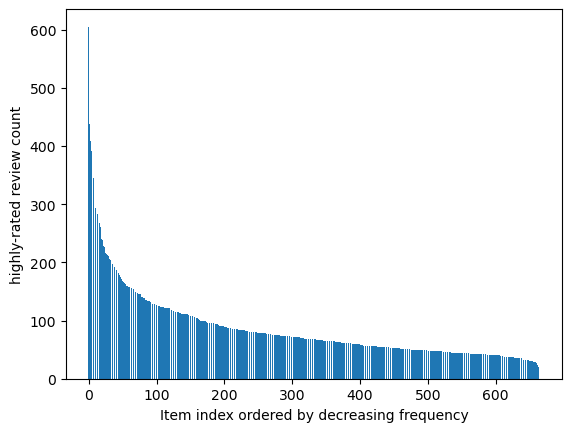

In [245]:
df_train_high_ratings_count_per_item = df_train[["item_id","rating"]].groupby("item_id", as_index=False).agg(lambda x: sum([1 if item >= 3.0 else 0 for item in x])).sort_values("rating", ascending=False)
plt.bar(x=range(df_train_high_ratings_count_per_item.shape[0]), height=df_train_high_ratings_count_per_item.iloc[:,1])
plt.xlabel("Item index ordered by decreasing frequency")
plt.ylabel("highly-rated review count")
plt.show()

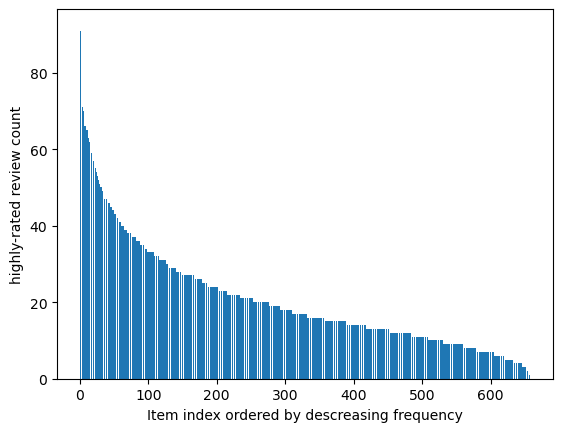

In [246]:
df_test_high_ratings_count_per_item = df_test[["item_id","rating"]].groupby("item_id", as_index=False).agg(lambda x: sum([1 if item >= 3.0 else 0 for item in x])).sort_values("rating", ascending=False)
plt.bar(x=range(df_test_high_ratings_count_per_item.shape[0]), height=df_test_high_ratings_count_per_item.iloc[:,1])
plt.xlabel("Item index ordered by descreasing frequency")
plt.ylabel("highly-rated review count")
plt.show()

In [252]:
print("Train dataset top 5 most highly rated items:")
print(avg_item_rating_training_dataset.sort_values(["avg_rating", "count"], ascending=[False, False]).iloc[:10,:])

Train dataset top 5 most highly rated items:
                                   item_id  avg_rating  count
15   0x871877255c288679:0x48bf59554f723fd7    4.953125     64
1    0x86e06303071072f3:0x36d1188767bf20c3    4.916667     60
6    0x871830fbd3debbd9:0x4b42bb0128441324    4.857143     49
3    0x86e37913c4b8d75b:0x6ed43df7bd3bb2bd    4.850000     40
205  0x87220b36739a31b3:0x43c4a7597d6351e8    4.833333     42
5    0x871776f5c94bbfb5:0x90a46d95988cb141    4.812500     32
97   0x87219a88f063bb53:0x9b3a6d62cb0799e9    4.777778    270
435  0x872271ad02e77f27:0x97b40641412c8108    4.772727    132
289   0x87220cd1698d1ae9:0x203b9e03fbc42b0    4.772727     44
7    0x87183f6c1fa8f349:0xe0d68faec57c2eac    4.772152    158


In [271]:
df_train[df_train["rating"] >= 3].groupby("item_id", as_index=False).agg(cnt=('rating','size'), avg_rating=('rating', 'mean')).sort_values(["cnt"], ascending=[True])[:500]

,item_id,cnt,avg_rating
449,0x8722725abd728c69:0x466af4bb77a6c838,14,4.642857
585,0x872274fe59d07317:0xd97ade296a2b98e3,20,4.500000
89,0x8718a0e561699ce1:0xb6ca44d9adc8c096,23,4.304348
388,0x872271412640b1c7:0x8283fb69fe981add,26,4.807692
42,0x8718a009b45200ab:0xb7d3427803029c67,27,4.407407
...,...,...,...
164,0x87220ad2f26cb1bf:0xf7f2ad27517d210,100,4.360000
132,0x87220ac606868067:0x43aad736cdc02ea0,100,4.330000
470,0x872272bffbd5a4e7:0x9f64efc9931ba886,100,4.290000
319,0x87220d6b3041d9ff:0xc07425e14a930fd3,100,4.500000


In [272]:
avg_item_rating_training_dataset.sort_values( ["count"], ascending=[False])

,item_id,avg_rating,count
167,0x87220ad48e49ced1:0x82bd3f558485505c,4.139423,624
409,0x872271688d36229b:0x60141c87d64d41ca,4.050000,460
280,0x87220cc2cc1c1055:0x52cc653371258502,4.572082,437
572,0x872274f254281dcd:0xa6cd03e496f6c6eb,4.413876,418
646,0x872276020cb23777:0x2d5c044ddafd9232,4.243309,411
...,...,...,...
245,0x87220bc3e97c8f0f:0x734478e98fb82dbc,4.535714,28
388,0x872271412640b1c7:0x8283fb69fe981add,4.666667,27
89,0x8718a0e561699ce1:0xb6ca44d9adc8c096,4.080000,25
585,0x872274fe59d07317:0xd97ade296a2b98e3,4.500000,20


In [16]:
print("Test dataset top 5 most highly rated items:")
print(avg_item_rating_test_dataset.sort_values(["avg_rating", "count"], ascending=[False, False]).iloc[:5,:])

Test dataset top 5 most highly rated items:
                                   item_id  avg_rating  count
6    0x871830fbd3debbd9:0x4b42bb0128441324         5.0     13
635  0x872275bfafb5f321:0xcd7fd72cfca5d05b         5.0     13
1    0x86e06303071072f3:0x36d1188767bf20c3         5.0      9
3    0x86e37913c4b8d75b:0x6ed43df7bd3bb2bd         5.0      9
185  0x87220b14ac00d62d:0x5efbaa5fcc7e7648         5.0      8


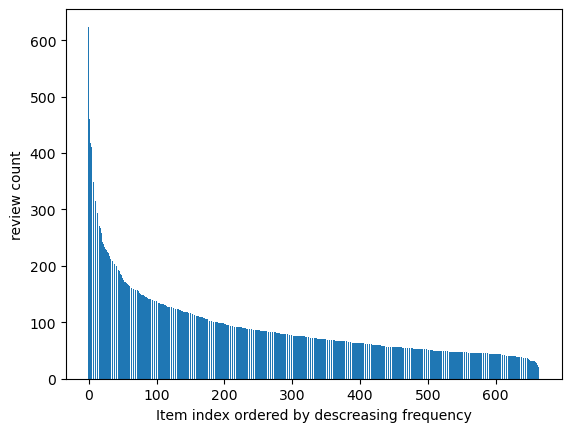

In [17]:
df_per_item_review_count_train_dataset = df_train.groupby("item_id", as_index=False).size().sort_values(["size"], ascending=[False])
plt.bar(x=range(df_per_item_review_count_train_dataset.shape[0]), height=df_per_item_review_count_train_dataset.iloc[:,1])
plt.xlabel("Item index ordered by descreasing frequency")
plt.ylabel("review count")
plt.show()

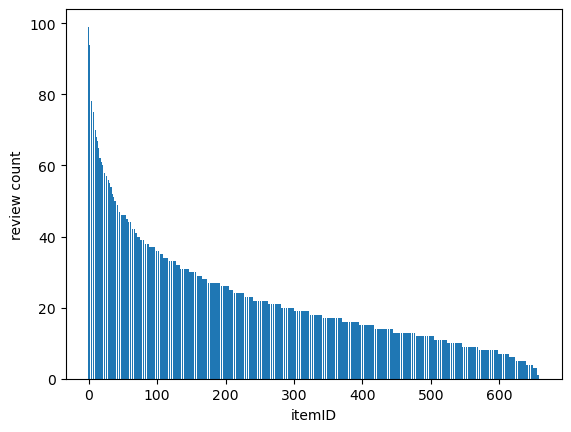

In [18]:
import matplotlib.pyplot as plt

df_per_item_review_count_test_dataset = df_test.groupby("item_id", as_index=False).size().sort_values(["size"], ascending=[False])
plt.bar(x=range(df_per_item_review_count_test_dataset.shape[0]), height=df_per_item_review_count_test_dataset.iloc[:,1])
plt.xlabel("itemID")
plt.ylabel("review count")
plt.show()

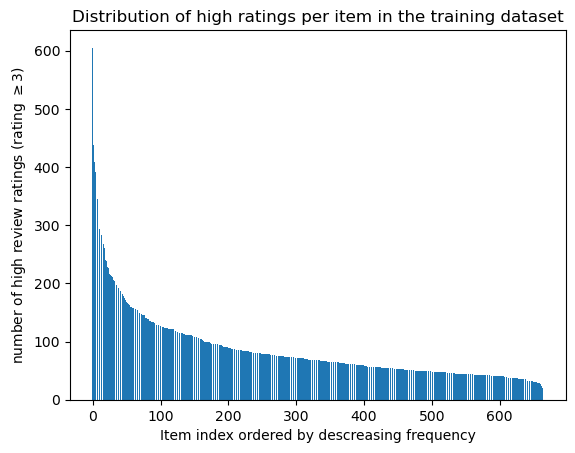

In [242]:
count_high_ratings_per_item_train = df_train[df_train["rating"] >= 3]["item_id"].value_counts()
plt.bar(x=range(count_high_ratings_per_item_train.shape[0]), height=count_high_ratings_per_item_train)
plt.xlabel("Item index ordered by descreasing frequency")
plt.ylabel(r"number of high review ratings (rating $\geq$3)")
plt.title("Distribution of high ratings per item in the training dataset")
plt.show()

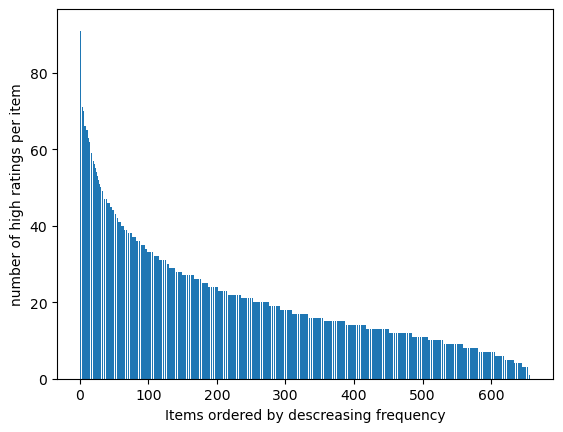

In [20]:
count_high_ratings_per_item_test = df_test[df_test["rating"] >= 3]["item_id"].value_counts()
plt.bar(x=range(count_high_ratings_per_item_test.shape[0]), height=count_high_ratings_per_item_test)
plt.xlabel("Items ordered by descreasing frequency")
plt.ylabel("number of high ratings per item")
plt.show()

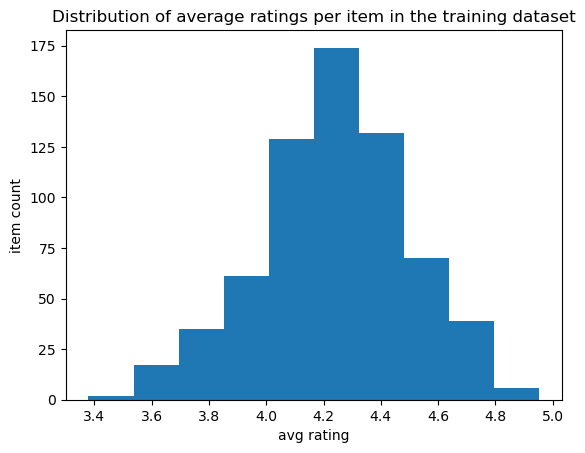

In [240]:
df_per_item_review_avg_rating_train_dataset = df_train.groupby("item_id")["rating"].mean()
plt.hist(df_per_item_review_avg_rating_train_dataset)
plt.xlabel("avg rating")
plt.ylabel("item count")
plt.title("Distribution of average ratings per item in the training dataset")
plt.show()

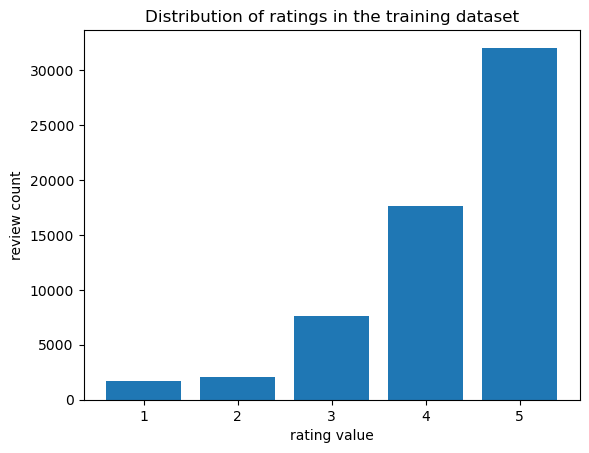

In [241]:
df_per_item_review_avg_rating_train_dataset = df_train["rating"]
plt.bar(*np.unique(df_train["rating"], return_counts=True))
plt.xlabel("rating value")
plt.ylabel("review count")
plt.title("Distribution of ratings in the training dataset")
plt.show()

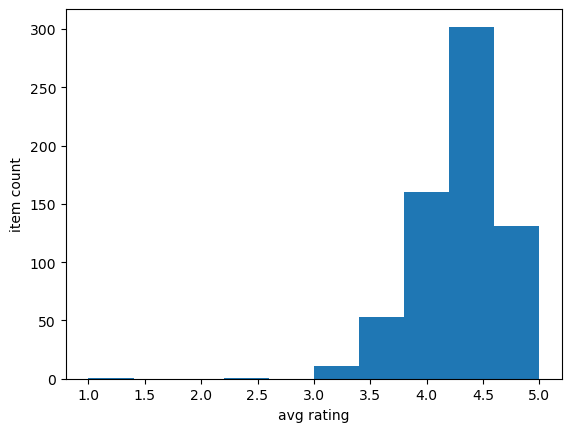

In [23]:
df_per_item_review_avg_rating_test_dataset = df_test.groupby("item_id")["rating"].mean()
plt.hist(df_per_item_review_avg_rating_test_dataset)
plt.xlabel("avg rating")
plt.ylabel("item count")
plt.show()

The discrepancy between the distributions in the train and test dataset is concerning. Given that in the training dataset all of the ratings are >=3, this would mean that for unobserved items the system will predict ratings >=3. However, in reality the real rating might be lower than 3.

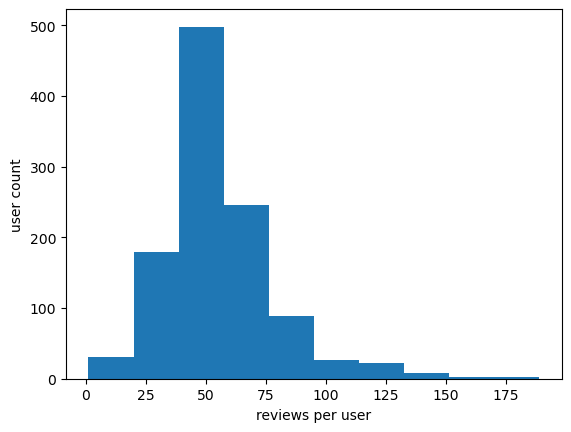

In [24]:
df_per_item_review_count_train_dataset = df_train.groupby("user_id").size()
plt.hist(df_per_item_review_count_train_dataset)
plt.xlabel("reviews per user")
plt.ylabel("user count")
plt.show()

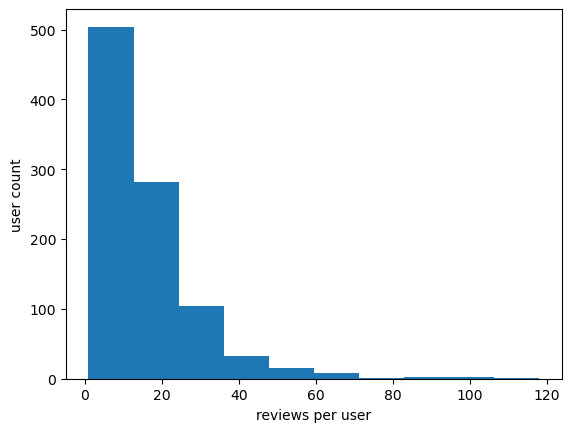

In [25]:
df_per_item_review_count_test_dataset = df_test.groupby("user_id").size()
plt.hist(df_per_item_review_count_test_dataset)
plt.xlabel("reviews per user")
plt.ylabel("user count")
plt.show()

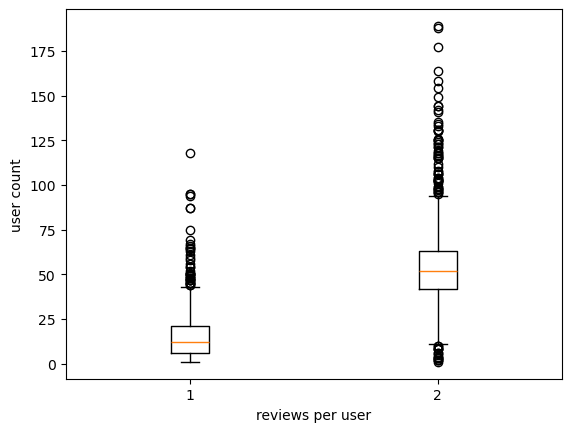

In [26]:
df_per_item_review_count_test_dataset = df_test.groupby("user_id").size()
plt.boxplot([df_per_item_review_count_test_dataset, df_per_item_review_count_train_dataset])
plt.xlabel("reviews per user")
plt.ylabel("user count")
plt.show()

In [10]:
# Data sparsity
unique_users_num = len(set(df_train.user_id.tolist()) | set(df_test.user_id.tolist()))
unique_items_num = len(set(df_train.item_id.tolist()) | set(df_test.item_id.tolist()))

print(f"Number of users {unique_users_num}")
print(f"Number of items {unique_items_num}")

num_test_dataset_user_not_in_training_dataset = len(set(df_test.user_id.tolist()).difference(set(df_train.user_id.tolist())))
print(f"Number of user in the test dataset that aren't present in the training dataset: {num_test_dataset_user_not_in_training_dataset}")


num_test_dataset_user_not_in_training_dataset = len(set(df_test.item_id.tolist()).difference(set(df_train.item_id.tolist())))
print(f"Number of items in the test dataset that aren't present in the training dataset: {num_test_dataset_user_not_in_training_dataset}")

data_sparsity = 1.0 - (df_train.shape[0] + df_test.shape[0])/ (unique_users_num * unique_items_num)
print(f"Data sparsity is :{data_sparsity}")

Number of users 1105
Number of items 666
Number of user in the test dataset that aren't present in the training dataset: 0
Number of items in the test dataset that aren't present in the training dataset: 1
Data sparsity is :0.8972198442786679


In [328]:
set(df_test.item_id.tolist()).difference(set(df_train.item_id.tolist()))

{'0x872273d603494715:0xd40fa343854d1a1b'}

In [329]:
df_test[df_test.item_id == '0x872273d603494715:0xd40fa343854d1a1b']

,item_id,user_id,rating,time
18894,0x872273d603494715:0xd40fa343854d1a1b,1.000827e+20,5.0,1607823528407
12553,0x872273d603494715:0xd40fa343854d1a1b,1.003802e+20,5.0,1607530678558
5202,0x872273d603494715:0xd40fa343854d1a1b,1.004122e+20,4.0,1607882750757
2378,0x872273d603494715:0xd40fa343854d1a1b,1.006549e+20,5.0,1596155416968
7975,0x872273d603494715:0xd40fa343854d1a1b,1.007926e+20,5.0,1611015744845
...,...,...,...,...
14946,0x872273d603494715:0xd40fa343854d1a1b,1.170402e+20,5.0,1614297447619
449,0x872273d603494715:0xd40fa343854d1a1b,1.170865e+20,1.0,1614916030883
6841,0x872273d603494715:0xd40fa343854d1a1b,1.173986e+20,4.0,1616612072751
14911,0x872273d603494715:0xd40fa343854d1a1b,1.176273e+20,5.0,1618025489134


So they \# users and \# items are relatively on the same order. So one cannot directly tell whether user-based or item-based is more appropriate. If users were orders of magnituded more than the items, then item-based would have been preferable

# Exercise 2

In [11]:
import random
my_seed = 1234
random.seed(my_seed)
np.random.seed(my_seed)

In [12]:
RATING_RELEVANCE_THRESHOLD = 4.0
RECOMMENDATION_LIST_CUTOFF = 10
RECOMMENDATION_LIST_CUTOFF_FOR_HYBRID_SYSTEM_USE = 30

## Baseline models

### TopPop

In [92]:
class TopPopRecommender:
    def __init__(self):
        self.popularity_df = None
        
    def fit(self, dataset_df: pd.DataFrame, rating_threshold: float = 3.0):
        self.popularity_df = dataset_df[["item_id","rating"]]\
                .groupby("item_id", as_index=False)\
                .agg(high_ratings_count=("rating", lambda x: sum([1 if item >= rating_threshold else 0 for item in x])), avg_rating=("rating","mean")) \
                .sort_values(["high_ratings_count", "avg_rating"], ascending=False)
    
    def get_top_k_most_rated_highly_rated_items(self, k):
        return self.popularity_df.head(k)

In [93]:
rec = TopPopRecommender()
rec.fit(df_train, RATING_RELEVANCE_THRESHOLD)
rec.get_top_k_most_rated_highly_rated_items(10)

,item_id,high_ratings_count,avg_rating
167,0x87220ad48e49ced1:0x82bd3f558485505c,484,4.139423
280,0x87220cc2cc1c1055:0x52cc653371258502,391,4.572082
572,0x872274f254281dcd:0xa6cd03e496f6c6eb,373,4.413876
146,0x87220acf0b6322a3:0x2be2da70bf431247,346,4.349127
646,0x872276020cb23777:0x2d5c044ddafd9232,337,4.243309
307,0x87220d2a464cfdc5:0xb18175d056d2b596,333,4.719198
409,0x872271688d36229b:0x60141c87d64d41ca,331,4.050000
122,0x87220ac427fec7d9:0x624c69a5b168d0b9,306,4.194937
250,0x87220c829e0184b1:0xf18c8205e14928e9,305,4.633846
531,0x87227491ca58a613:0x931ee5a1891df9c5,281,4.466877


### Random recommender

In [94]:
import random
class RandomRecommender:
    def __init__(self, dataset_df):
        self.items = dataset_df['item_id'].unique().tolist()
    
    def get_random_k_recommendations(self, k):
        return random.choices(self.items, k=k)        

In [95]:
rec = RandomRecommender(df_train)

In [96]:
rec.get_random_k_recommendations(5)

['0x872270bffc6347ad:0x9fb06edf63c5d37d',
 '0x8722716ee269eaaf:0x22a5cca4a1ee1dfc',
 '0x87220ac607815f9b:0x3d531a777c8eb85',
 '0x8722718683d555b7:0x5582f83d57ea952',
 '0x87189e66c2c4b315:0x159b1017daeaac02']

Models chosen -> NeuMF, KNNWithMeans, Latent factor model + SVD + user bias + item bias, Graph based ->

# Exercise 3

In [13]:
from surprise import Reader, KNNWithMeans, SVD, Dataset
from sklearn.metrics import root_mean_squared_error as rmse
from metrics import *
from utils import *

In [14]:
num_folds = 5 # increased from 3 to 5 to get more stable results

reader = Reader(rating_scale=(1, 5))
training_matrix = Dataset.load_from_df(df_train[['user_id', 'item_id','rating']], reader)

## SVD

In [ ]:
from custom_cv_recommender import CustomGridSearchCV
import math
param_grid = {
    "random_state" : [my_seed],
    "n_factors" : [2, 5, 10, 15, 20, 25, 30],
    "n_epochs": [20, 50, 100, 1000, 5000]
}

cv_search = CustomGridSearchCV(
        algorithm_class=SVD,
        param_grid=param_grid,
        measures=['mrr', 'hit_rate'],
        rating_relevance_threshold=RATING_RELEVANCE_THRESHOLD,
        k_cutoff=RECOMMENDATION_LIST_CUTOFF,
        cv=num_folds,
        random_state=my_seed,
    )
    
cv_search.fit(df_train)

In [42]:
from custom_cv_recommender import CustomGridSearchCV
import math
param_grid = {
    "random_state" : [my_seed],
    "n_factors" : [20, 30],
    "n_epochs": [10, 50]
}

cv_search = CustomGridSearchCV(
        algorithm_class=SVD,
        param_grid=param_grid,
        measures=['mrr', 'hit_rate'],
        rating_relevance_threshold=RATING_RELEVANCE_THRESHOLD,
        k_cutoff=RECOMMENDATION_LIST_CUTOFF,
        cv=num_folds,
        random_state=my_seed,
    )
    
cv_search.fit(df_train)

100%|██████████| 4/4 [02:56<00:00, 44.08s/it]


{'mrr': {'random_state': 1234, 'n_factors': 20, 'n_epochs': 50},
 'hit_rate': {'random_state': 1234, 'n_factors': 20, 'n_epochs': 50}}

{'mrr': 0.0535544301075831, 'hit_rate': 0.16542390149988045}

## User-based KNN

In [45]:
import math
math.sqrt(df_train.user_id.unique().size)

33.24154027718932

In [ ]:
from custom_cv_recommender import CustomGridSearchCV
param_grid = {
    "random_state" : [my_seed],
    "k" : list(range(1, 33, 1)),
    "verbose": [False],
    "sim_options": [
        { "user_based": True, "name": "cosine"},
        { "user_based": True, "name": "pearson"},
    ]
}

cv_search = CustomGridSearchCV(
        algorithm_class=KNNWithMeans,
        param_grid=param_grid,
        measures=['mrr', 'hit_rate'],
        rating_relevance_threshold=RATING_RELEVANCE_THRESHOLD,
        k_cutoff=RECOMMENDATION_LIST_CUTOFF,
        cv=num_folds,
        random_state=my_seed,
    )
    
# Perform hyperparameter search
cv_search.fit(df_train)


{'params': {'random_state': 1234,
   'k': 4,
   'verbose': False,
   'sim_options': {'user_based': True, 'name': 'pearson'}},
  'mrr': 0.05324070755223325,
  'hit_rate': 0.1638504697886989},

## Item-based KNN

In [ ]:
from custom_cv_recommender import CustomGridSearchCV
param_grid = {
    "random_state" : [my_seed],
    "k" : list(range(1, 33, 1)),
    "verbose": [False],
    "sim_options": [
        { "user_based": False, "name": "cosine"},
        { "user_based": False, "name": "pearson"},
    ]
}

cv_search = CustomGridSearchCV(
        algorithm_class=KNNWithMeans,
        param_grid=param_grid,
        measures=['mrr', 'hit_rate'],
        rating_relevance_threshold=RATING_RELEVANCE_THRESHOLD,
        k_cutoff=RECOMMENDATION_LIST_CUTOFF,
        cv=num_folds,
        random_state=my_seed,
    )
    
# Perform hyperparameter search
cv_search.fit(df_train)


[
  {'params': {'random_state': 1234,
   'k': 1,
   'verbose': False,
   'sim_options': {'user_based': False, 'name': 'pearson'}},
  'mrr': 0.05466772763633107,
  'hit_rate': 0.16904183225225944},

 {'params': {'random_state': 1234,
   'k': 4,
   'verbose': False,
   'sim_options': {'user_based': False, 'name': 'pearson'}},
  'mrr': 0.054505399095281445,
  'hit_rate': 0.16136116818155585}
]

## Generating rating predictions on the unobserved user-item combinations

Running each model with its best combination of hyperparameters

In [97]:
# Initially the type of KNN (user/item based) was used as a hyperparameter. And the Grid search's result always pointed
# towards using an item-based one. However, exercise 8 requires from us to have also an user-based one.
user_based_knn = KNNWithMeans(k=4,
                   sim_options={"name":"pearson","user_based":True},
                   verbose=False,
                   random_state=my_seed)

item_based_knn = KNNWithMeans(k=4,
                   sim_options={"name":"pearson","user_based":False},
                   verbose=False,
                   random_state=my_seed)

svd_lmf = SVD(n_factors=20, n_epochs=50, random_state=my_seed)


toppop = TopPopRecommender()
toppop.fit(df_train, RATING_RELEVANCE_THRESHOLD)

random_rec = RandomRecommender(df_train)

In [98]:
model_prediction = {}
models = {"user_based_knn": user_based_knn, "item_based_knn": item_based_knn, "svd_lmf": svd_lmf}

for name, model in models.items():
    
    train_data = training_matrix.build_full_trainset()
    model.fit(train_data)

    unobserved_user_item_set = train_data.build_anti_testset()

    model_pred = model.test(unobserved_user_item_set) 
    df_model_pred = pd.DataFrame(model_pred)
    model_prediction[name] = df_model_pred

In [99]:
from metrics import *

In [100]:
import pickle
with open("./models/user_based_knn_model.pkl", "wb") as handle:
    pickle.dump(user_based_knn, handle)

In [101]:
import pickle
with open("./models/item_based_knn_model.pkl", "wb") as handle:
    pickle.dump(item_based_knn, handle)

In [102]:
import pickle
item_based_knn_top_10_recommendations_per_user = get_top_k(model_prediction["item_based_knn"], RECOMMENDATION_LIST_CUTOFF)
with open('./recommendation_lists/item_based_knn_top_10_recommendations_per_user.pickle', 'wb') as handle:
    pickle.dump(item_based_knn_top_10_recommendations_per_user, handle)

In [103]:
import pickle
item_based_knn_top_30_recommendations_per_user = get_top_k(model_prediction["item_based_knn"], RECOMMENDATION_LIST_CUTOFF_FOR_HYBRID_SYSTEM_USE)
with open('./recommendation_lists/item_based_knn_top_30_recommendations_per_user.pickle', 'wb') as handle:
    pickle.dump(item_based_knn_top_30_recommendations_per_user, handle)

In [104]:
import pickle
user_based_knn_top_10_recommendations_per_user = get_top_k(model_prediction["user_based_knn"], RECOMMENDATION_LIST_CUTOFF)
with open('./recommendation_lists/user_based_knn_top_10_recommendations_per_user.pickle', 'wb') as handle:
    pickle.dump(user_based_knn_top_10_recommendations_per_user, handle)

In [105]:
import pickle
user_based_knn_top_30_recommendations_per_user = get_top_k(model_prediction["user_based_knn"], RECOMMENDATION_LIST_CUTOFF_FOR_HYBRID_SYSTEM_USE)
with open('./recommendation_lists/user_based_knn_top_30_recommendations_per_user.pickle', 'wb') as handle:
    pickle.dump(user_based_knn_top_30_recommendations_per_user, handle)

In [106]:
import pickle
item_based_knn_top_30_recommendations_per_user = get_top_k(model_prediction["item_based_knn"], RECOMMENDATION_LIST_CUTOFF_FOR_HYBRID_SYSTEM_USE)
with open('./recommendation_lists/item_based_knn_top_30_recommendations_per_user.pickle', 'wb') as handle:
    pickle.dump(item_based_knn_top_30_recommendations_per_user, handle)

In [107]:
import pickle
item_based_knn_top_10_recommendations_per_user = get_top_k(model_prediction["item_based_knn"], RECOMMENDATION_LIST_CUTOFF)
with open('./recommendation_lists/item_based_knn_top_10_recommendations_per_user.pickle', 'wb') as handle:
    pickle.dump(item_based_knn_top_10_recommendations_per_user, handle)

In [108]:
import pickle
item_based_knn_top_10_recommendations_per_user = get_top_k(model_prediction["item_based_knn"], RECOMMENDATION_LIST_CUTOFF, include_est_rating=True)
with open('./recommendation_lists/item_based_knn_top_10_recommendations_and_rating_per_user.pickle', 'wb') as handle:
    pickle.dump(item_based_knn_top_10_recommendations_per_user, handle)

In [109]:
import pickle
item_based_knn_top_30_recommendations_per_user = get_top_k(model_prediction["item_based_knn"], RECOMMENDATION_LIST_CUTOFF_FOR_HYBRID_SYSTEM_USE, include_est_rating=True)
with open('./recommendation_lists/item_based_knn_top_30_recommendations_and_rating_per_user.pickle', 'wb') as handle:
    pickle.dump(item_based_knn_top_30_recommendations_per_user, handle)

In [110]:
import pickle
svd_top_k_recommendations_per_user = get_top_k(model_prediction["svd_lmf"], RECOMMENDATION_LIST_CUTOFF)
with open('./recommendation_lists/svd_top_10_recommendations_per_user.pickle', 'wb') as handle:
    pickle.dump(svd_top_k_recommendations_per_user, handle)

In [111]:
list_of_users_in_train_set = df_train.user_id.unique().tolist()

In [112]:
import pickle
with open('./recommendation_lists/toppop_top_10_recommendations_per_user.pickle', 'wb') as handle:
    pickle.dump({user: toppop.get_top_k_most_rated_highly_rated_items(RECOMMENDATION_LIST_CUTOFF).item_id.tolist() for user in list_of_users_in_train_set}, handle)

In [113]:
import pickle
with open('./recommendation_lists/random_rec_top_10_recommendations_per_user.pickle', 'wb') as handle:
    pickle.dump({user: random_rec.get_random_k_recommendations(RECOMMENDATION_LIST_CUTOFF) for user in list_of_users_in_train_set}, handle)

# Exercise 4

Metadata.tsv contains 2 items without titles and 6423 items without description

In [15]:
import pandas as pd
import numpy as np
from text_data_preprocessing_utils import *
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/danielpenchev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/danielpenchev/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielpenchev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/danielpenchev/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
# some items might not have 
item_metadata = pd.read_csv("metadata.tsv", sep="\t")

In [25]:
item_metadata.shape

(4409, 6)

In [26]:
item_metadata[item_metadata.description.notna() & item_metadata.name.notna()].shape

(4409, 6)

All metadata entries don't suffer from missing name or description

In [27]:
catalog_items = set(df_train.item_id.unique()) | set(df_test.item_id.unique())

# The description might be allowed to be missing, but the name shouldn't be
filtered_item_metadata = item_metadata[item_metadata.item_id.isin(catalog_items) & item_metadata.name.notna() ] \
     .drop_duplicates(['item_id'])

item_descriptions = filtered_item_metadata.description.tolist()
item_id_name_and_description = list(filtered_item_metadata[["item_id","name", "description"]].itertuples(index=False, name=None))

Should we only keep a single location of a chain, instead of keeping all locations? If the current location of the user is taken into consideration, then maybe it makes sence - if one lives in NY and loves fast food, then mac donalds store in NY should be prefered than mac donals in Dubai

4 rows were dropped due to begin duplicates, and 4409 - 666 were dropped due to not being in the training or test dataset

In [10]:
filtered_item_metadata.shape

NameError: name 'filtered_item_metadata' is not defined

why using only metadata for the items in the train/test dataset

In [11]:
comparison_samples = {
    '0x87227339ff929717:0x3422514fbdbffc0': "Indian Pueblo Cultural Center - Native American museum",
    '0x87220cd2b519870f:0x780df887461461f6': "New Mexico Museum of Natural History and Science",
    '0x87220ad3aaeabf87:0x79d5bcd7ff1266dd': "LongHorn Steakhouse",
    "0x872274efda7f0051:0x30146b7f3460f963": "Outback Steakhouse",
    "0x8722717d2d4eb66d:0x246f16d0e5892e05": "Target (electronics, clothing)"
}

<!-- 0x87220b6ca620427b:0xc016c8e82ed9b361 - Flying Star Cafe

0x872274ff688859d5:0x8907d6ed1633ef98 - starbucks -->


0x87227339ff929717:0x3422514fbdbffc0,Indian Pueblo Cultural Center - Native American museum

0x87220cd2b519870f:0x780df887461461f6,New Mexico Museum of Natural History and Science

0x87220ad3aaeabf87:0x79d5bcd7ff1266dd - LongHorn Steakhouse

0x872274efda7f0051:0x30146b7f3460f963 - Outback Steakhouse

0x8722717d2d4eb66d:0x246f16d0e5892e05 - Target (electronics, clothing)


## TF-IDF

In [402]:
from sklearn.feature_extraction.text import TfidfVectorizer

lemmatizer = get_lemmatizer()

item_ids_and_item_text_representations = [(item, preprocessing(name) + " " + preprocessing(description)) for item, name, description in item_id_name_and_description]

unified_vocab = build_vocab([text_rep for _, text_rep in item_ids_and_item_text_representations], lemmatizer=lemmatizer)
processed_text_representations = [preprocessing(text_rep,  lemmatizer=lemmatizer) for _,text_rep in item_ids_and_item_text_representations]

vectorizer = TfidfVectorizer(vocabulary=unified_vocab, tokenizer=lambda x: x.split(' '), token_pattern=None)
tf_idf_item_representations = vectorizer.fit_transform(processed_text_representations)
dataframe_with_tf_idf_item_representations = pd.DataFrame(tf_idf_item_representations.toarray())
dataframe_with_tf_idf_item_representations.index=filtered_item_metadata.item_id.tolist()

Vocab size before preprocessing: 1757
Vocab size after preprocessing: 1644


In [403]:
tfidf_embedding_index_of_sample_item = []
for sample_item_id in comparison_samples.keys():
    for i,(item_id, _, _) in enumerate(item_id_name_and_description):
        if sample_item_id == item_id:
            tfidf_embedding_index_of_sample_item.append(i)
            break

In [406]:
print(comparison_samples.keys())
print(comparison_samples.values())
cosine_similarity(
    dataframe_with_tf_idf_item_representations.iloc[tfidf_embedding_index_of_sample_item],
    dataframe_with_tf_idf_item_representations.iloc[tfidf_embedding_index_of_sample_item]
)

dict_keys(['0x87227339ff929717:0x3422514fbdbffc0', '0x87220cd2b519870f:0x780df887461461f6', '0x87220ad3aaeabf87:0x79d5bcd7ff1266dd', '0x872274efda7f0051:0x30146b7f3460f963', '0x8722717d2d4eb66d:0x246f16d0e5892e05'])
dict_values(['Indian Pueblo Cultural Center - Native American museum', 'New Mexico Museum of Natural History and Science', 'LongHorn Steakhouse', 'Outback Steakhouse', 'Target (electronics, clothing)'])


array([[1.        , 0.20514545, 0.02318575, 0.        , 0.        ],
       [0.20514545, 1.        , 0.        , 0.        , 0.        ],
       [0.02318575, 0.        , 1.        , 0.34557284, 0.00861421],
       [0.        , 0.        , 0.34557284, 1.        , 0.00862163],
       [0.        , 0.        , 0.00861421, 0.00862163, 1.        ]])

## Word2Vec

In [19]:
import gensim.downloader
word2vec_vectors = gensim.downloader.load('word2vec-google-news-300')

In [18]:
build_vocab([name for _, name, _ in item_id_name_and_description])

Vocab size before preprocessing: 731
Vocab size after preprocessing: 658


{'abq',
 'abruzzo',
 'ace',
 'albuquerque',
 'alquds',
 'altamar',
 'alto',
 'altos',
 'amphitheater',
 'amusement',
 'andaluz',
 'anderson',
 'angel',
 'angus',
 'anita',
 'anitas',
 'apache',
 'applebee',
 'aquarium',
 'aquatic',
 'area',
 'arroyo',
 'artichoke',
 'asia',
 'asian',
 'avanyu',
 'ayce',
 'azul',
 'azuma',
 'baca',
 'backstreet',
 'bagels',
 'bahama',
 'bakery',
 'balloon',
 'bar',
 'bar-b-q',
 'barbecue',
 'barbeque',
 'barnes',
 'barrel',
 'basil',
 'basin',
 'bath',
 'bbq',
 'beach',
 'bed',
 'benavidez',
 'bender',
 'beppo',
 'bernalillo',
 'betty',
 'big',
 'biopark',
 'bistro',
 'bj',
 'black',
 'blake',
 'blaze',
 'blue',
 'bob',
 'boil',
 'bosque',
 'boston',
 'botanic',
 'bowl',
 'bravo',
 'brazilian',
 'bread',
 'breakfast',
 'brew',
 'brewery',
 'brewhouse',
 'brewyard',
 'brickyard',
 'bridge',
 'brixens',
 'bruno',
 'bubba',
 'buca',
 'buck',
 'buffalo',
 'buffet',
 'bullhead',
 'burger',
 'burgers',
 'burritos',
 'business',
 'buster',
 'butte',
 'cabana',

In [20]:
build_vocab([description for _, _, description in item_id_name_and_description])

Vocab size before preprocessing: 1405
Vocab size after preprocessing: 1289


{'original',
 'corner',
 'moody',
 'munchies',
 'broad',
 'cash-only',
 'serving',
 'ample',
 'brick-lined',
 'cottonwood',
 'liquor',
 'flavors',
 'jersey-based',
 'panini',
 'place',
 'heaping',
 'science',
 'imported',
 'york-style',
 'rancheros',
 'jazz',
 'self-service',
 'workwear',
 'schedule',
 'drive-in',
 'plates',
 'general',
 'festive',
 'upbeat',
 'stir-fries',
 'chicken',
 'stone',
 'opulent',
 'lots',
 'parties',
 'handmade',
 'extremely',
 'performance',
 'prepared',
 'exploratory',
 'egg',
 'counter-service',
 'setting',
 'made',
 'bento',
 'health-conscious',
 'beer',
 'wide',
 'ride',
 'pie',
 'seating',
 'produce',
 'mongolian',
 'vietnamese',
 'grocery',
 'softball',
 'livestock',
 'chinese',
 'range',
 'million',
 'releases',
 'founded',
 'sunday',
 'aquarium',
 'establishment',
 'santa',
 'carrying',
 'peak',
 'suites',
 'to-go',
 'soft',
 'swanky',
 'famous',
 'boxes',
 'dessert',
 'gift',
 'cantina',
 'posters',
 'flashy',
 'lunch',
 'arena',
 'hollywood',
 'li

In [21]:
item_ids_and_names = [(item, preprocessing(name)) for item, name, _ in item_id_name_and_description]
item_ids_and_descriptions = [(item, preprocessing(description)) for item, _, description in item_id_name_and_description]

In [346]:
def get_word2vec_item_representation(item_ids_and_item_text_representations):
    embedding_size = word2vec_vectors.vectors.shape[1]

    item_embeddings = []
    for _, text_representation in item_ids_and_item_text_representations:
        in_vocab_words = 0
        item_embedding = np.zeros((embedding_size,))
        for word in text_representation.split(" "):
            if word not in word2vec_vectors:
                continue
            item_embedding += word2vec_vectors[word]
            in_vocab_words+=1
        
        item_embeddings.append(item_embedding / max(in_vocab_words,1))
        
    return pd.DataFrame(item_embeddings, index=filtered_item_metadata.item_id.tolist())

In [347]:
df_item_name_embeddings = get_word2vec_item_representation(item_ids_and_names)
df_item_description_embeddings = get_word2vec_item_representation(item_ids_and_descriptions)

df_item_description_embeddings.columns = [df_item_name_embeddings.shape[1]+i for i in range(df_item_description_embeddings.shape[1])]

df_item_embeddings = pd.concat([df_item_name_embeddings, df_item_description_embeddings], axis=1)

# The order of the description/title representation is the same as the order of the string/text representations, hence we can directly set the indexes to the item_ids
df_item_embeddings.index=filtered_item_metadata.item_id.tolist()

In [348]:
sample_item_word2vec_embeddings = [df_item_embeddings.loc[sample_item_id] for sample_item_id in comparison_samples.keys()]

In [349]:
print(comparison_samples.values())
cosine_similarity(sample_item_word2vec_embeddings,sample_item_word2vec_embeddings)

dict_values(['Indian Pueblo Cultural Center - Native American museum', 'New Mexico Museum of Natural History and Science', 'LongHorn Steakhouse', 'Outback Steakhouse', 'Target (electronics, clothing)'])


array([[1.        , 0.57096353, 0.27431257, 0.29964508, 0.1332677 ],
       [0.57096353, 1.        , 0.23233291, 0.24095118, 0.11504036],
       [0.27431257, 0.23233291, 1.        , 0.69363843, 0.12671483],
       [0.29964508, 0.24095118, 0.69363843, 1.        , 0.10961328],
       [0.1332677 , 0.11504036, 0.12671483, 0.10961328, 1.        ]])

## Glove

In [533]:
import gensim.downloader
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-300')

In [539]:
item_ids_and_names = [(item, preprocessing(name)) for item, name, _ in item_id_name_and_description]
item_ids_and_descriptions = [(item, preprocessing(description)) for item, _, description in item_id_name_and_description]

In [540]:
def get_glove_item_representation(item_ids_and_item_text_representations):
    embedding_size = glove_vectors.vectors.shape[1]

    item_glove_embeddings = []
    for _, text_representation in item_ids_and_item_text_representations:
        in_vocab_words = 0
        item_glove_embedding = np.zeros((embedding_size,))
        for word in text_representation.split(" "):
            if word not in glove_vectors:
                continue
            item_glove_embedding += glove_vectors[word]
            in_vocab_words+=1
        
        item_glove_embeddings.append(item_glove_embedding / max(in_vocab_words,1))
        
    return pd.DataFrame(item_glove_embeddings, index=filtered_item_metadata.item_id.tolist())

In [541]:
df_item_name_embeddings = get_glove_item_representation(item_ids_and_names)
df_item_description_embeddings = get_glove_item_representation(item_ids_and_descriptions)

df_item_description_embeddings.columns = [df_item_name_embeddings.shape[1]+i for i in range(df_item_description_embeddings.shape[1])]

df_item_embeddings = pd.concat([df_item_name_embeddings, df_item_description_embeddings], axis=1)

# The order of the description/title representation is the same as the order of the string/text representations, hence we can directly set the indexes to the item_ids
df_item_embeddings.index=filtered_item_metadata.item_id.tolist()

In [542]:
sample_item_glove_embeddings = [df_item_embeddings.loc[sample_item_id] for sample_item_id in comparison_samples]

In [543]:
print(comparison_samples.values())
cosine_similarity(sample_item_glove_embeddings,sample_item_glove_embeddings)

dict_values(['Indian Pueblo Cultural Center - Native American museum', 'New Mexico Museum of Natural History and Science', 'LongHorn Steakhouse', 'Outback Steakhouse', 'Target (electronics, clothing)'])


array([[1.        , 0.58808939, 0.1167892 , 0.12645794, 0.28730365],
       [0.58808939, 1.        , 0.04671342, 0.00504079, 0.26214134],
       [0.1167892 , 0.04671342, 1.        , 0.75355788, 0.15853992],
       [0.12645794, 0.00504079, 0.75355788, 1.        , 0.1353547 ],
       [0.28730365, 0.26214134, 0.15853992, 0.1353547 , 1.        ]])

## BERT (Optional)

In [407]:
# LOAD TRANSFORMER
"""
If you plan on using a pretrained model, its important to use the associated 
pretrained tokenizer: it will split the text you give it in tokens the same way
for the pretraining corpus, and it will use the same correspondence
token to index (that we usually call a vocab) as during pretraining.
"""

# % pip install transformers
import torch
import transformers
assert transformers.__version__ > '4.0.0'

from transformers import BertModel, BertTokenizerFast

# set-up environment
DEVICE = "cpu"
print(f"Using device: {DEVICE}")


modelname = 'bert-base-uncased'
tokenizer = BertTokenizerFast.from_pretrained(modelname)
model = BertModel.from_pretrained(modelname).to(DEVICE)

# Print out the vocabulary size
print(tokenizer.vocab_size)
print(f"Max input size: {tokenizer.model_max_length}")
print(model.config.hidden_size)

Using device: cpu
30522
Max input size: 512
768


In [408]:
comparison_sample_text_representation = [(item, name + ". " + description) for item, name, description in item_id_name_and_description if item in comparison_samples]
item_ids  = [item for item, _ in comparison_sample_text_representation]
descriptions = [text for _, text in comparison_sample_text_representation]

In [409]:
descriptions

['LongHorn Steakhouse. Casual steakhouse chain known for grilled beef & other American dishes in a ranch-style space.',
 'Outback Steakhouse. Boisterous Australian-themed chain serving steaks, seafood & other hearty steakhouse fare.',
 'Target. Retail chain offering home goods, clothing, electronics & more, plus exclusive designer collections.',
 'Indian Pueblo Cultural Center. Expansive museum featuring pottery, arts & crafts, jewelry & more from local Native American tribes.',
 'New Mexico Museum of Natural History and Science. Expansive museum featuring stones & gems, dinosaur skeletons & a time travel simulation ride.']

In [410]:
# Represent products in a vector space
"""
When using pre-trained models, it is always advised to feed it data similar to what it was trained with. 
Basically, it doesn't hurt to keep all the words in.
However, the effect (or the lack of it) will vary based on corpus and task. 
Decision here: keep them all since pretraining was done that way.
"""

def batch_encoding(sentences):
    # Since we're using padding, we need to provide the attention masks to our
    # model. Otherwise it doesn't know which tokens it should not attend to. 
    # Make the tokenizer return encoded sequences with padding in pytorch tensor format
    inputs = tokenizer(sentences, padding=True, return_tensors='pt', max_length=tokenizer.model_max_length, truncation=True)
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state

    return inputs, inputs["attention_mask"], last_hidden_states
  
encoded_inputs, attention_masks, descriptions_last_hidden_states = batch_encoding(descriptions)
# Note that the control token [CLS] has been added at the beginning of each sentence,
# and [SEP] at the end

print(f"last_hidden_states: {descriptions_last_hidden_states.shape}")
# Let's mask out the padding tokens 

last_hidden_states: torch.Size([5, 27, 768])


In [69]:
avg_embeddings = torch.sum(descriptions_last_hidden_states * attention_masks.unsqueeze(-1), dim=1)
sentence_embeddings = (avg_embeddings / attention_masks.sum(dim=1, keepdim=True)).detach().numpy()


0x87227339ff929717:0x3422514fbdbffc0,Indian Pueblo Cultural Center - Native American museum

0x87220cd2b519870f:0x780df887461461f6,New Mexico Museum of Natural History and Science

0x87220ad3aaeabf87:0x79d5bcd7ff1266dd - LongHorn Steakhouse

0x872274efda7f0051:0x30146b7f3460f963 - Outback Steakhouse

0x8722717d2d4eb66d:0x246f16d0e5892e05 - Target (electronics, clothing)

In [73]:
print([comparison_samples[item_id] for item_id in item_ids])
cosine_similarity(sentence_embeddings,sentence_embeddings)

['LongHorn Steakhouse', 'Outback Steakhouse', 'Target (electronics, clothing)', 'Indian Pueblo Cultural Center - Native American museum', 'New Mexico Museum of Natural History and Science']


array([[0.9999999 , 0.8754874 , 0.67794895, 0.7210134 , 0.69704914],
       [0.8754874 , 0.99999964, 0.6971417 , 0.6982993 , 0.7115574 ],
       [0.67794895, 0.6971417 , 0.9999999 , 0.70237005, 0.67882526],
       [0.7210134 , 0.6982993 , 0.70237005, 1.0000001 , 0.84598225],
       [0.69704914, 0.7115574 , 0.67882526, 0.84598225, 1.0000001 ]],
      dtype=float32)

In [65]:
descriptions

['LongHorn Steakhouse. Casual steakhouse chain known for grilled beef & other American dishes in a ranch-style space.',
 'Outback Steakhouse. Boisterous Australian-themed chain serving steaks, seafood & other hearty steakhouse fare.',
 'Target. Retail chain offering home goods, clothing, electronics & more, plus exclusive designer collections.',
 'Indian Pueblo Cultural Center. Expansive museum featuring pottery, arts & crafts, jewelry & more from local Native American tribes.',
 'New Mexico Museum of Natural History and Science. Expansive museum featuring stones & gems, dinosaur skeletons & a time travel simulation ride.']

In [75]:
# Using the output corresponding to the [CLS] token -> aka the class p
sentence_embeddings = descriptions_last_hidden_states[:,0,:].detach().numpy()
print([comparison_samples[item_id] for item_id in item_ids])
cosine_similarity(sentence_embeddings,sentence_embeddings)

['0x87220ad3aaeabf87:0x79d5bcd7ff1266dd', '0x872274efda7f0051:0x30146b7f3460f963', '0x8722717d2d4eb66d:0x246f16d0e5892e05', '0x87227339ff929717:0x3422514fbdbffc0', '0x87220cd2b519870f:0x780df887461461f6']


array([[0.9999999 , 0.83270985, 0.8837442 , 0.849699  , 0.8386376 ],
       [0.83270985, 1.        , 0.7969275 , 0.7193362 , 0.7891153 ],
       [0.8837442 , 0.7969275 , 0.99999976, 0.8070799 , 0.80068576],
       [0.849699  , 0.7193362 , 0.8070799 , 0.99999994, 0.8564726 ],
       [0.8386376 , 0.7891153 , 0.80068576, 0.8564726 , 0.9999999 ]],
      dtype=float32)

## Sentence-BERT (Optional)

In [31]:
comparison_sample_descriptions = [(item, name + ". " + description) for item, name, description in item_id_name_and_description if item in comparison_samples]
item_ids  = [item for item, _ in comparison_sample_descriptions]
descriptions = [description for item, description in comparison_sample_descriptions]

In [32]:
from sentence_transformers import SentenceTransformer

# 1. Load a pretrained Sentence Transformer model
model = SentenceTransformer("all-MiniLM-L6-v2", device='cpu')

# 2. Calculate embeddings by calling model.encode()
embeddings = model.encode(descriptions)

# 3. Calculate the embedding similarities
similarities = model.similarity(embeddings, embeddings)
print([comparison_samples[item_id] for item_id in item_ids])
print(similarities)

['LongHorn Steakhouse', 'Outback Steakhouse', 'Target (electronics, clothing)', 'Indian Pueblo Cultural Center - Native American museum', 'New Mexico Museum of Natural History and Science']
tensor([[1.0000, 0.5739, 0.1945, 0.1929, 0.1569],
        [0.5739, 1.0000, 0.1915, 0.1408, 0.1625],
        [0.1945, 0.1915, 1.0000, 0.1097, 0.0723],
        [0.1929, 0.1408, 0.1097, 1.0000, 0.5639],
        [0.1569, 0.1625, 0.0723, 0.5639, 1.0000]])


In [77]:
descriptions

['LongHorn Steakhouse. Casual steakhouse chain known for grilled beef & other American dishes in a ranch-style space.',
 'Outback Steakhouse. Boisterous Australian-themed chain serving steaks, seafood & other hearty steakhouse fare.',
 'Target. Retail chain offering home goods, clothing, electronics & more, plus exclusive designer collections.',
 'Indian Pueblo Cultural Center. Expansive museum featuring pottery, arts & crafts, jewelry & more from local Native American tribes.',
 'New Mexico Museum of Natural History and Science. Expansive museum featuring stones & gems, dinosaur skeletons & a time travel simulation ride.']

## Algorithm pick

It is a good idea to use cross-validation procedure on the training dataset to pick which type of content-based recommender to pick

# Exercise 5

In [17]:
import pandas as pd
import numpy as np
from text_data_preprocessing_utils import *
from sklearn.metrics.pairwise import cosine_similarity
from content_based_recommender_system_utils import *

No items that have both no title or descriptions, hence can take advantage of at least one of them.

In [18]:
item_metadata = pd.read_csv("metadata.tsv", sep="\t")

item_catalog = set(df_train.item_id.unique()) | set(df_test.item_id.unique())

# all metadata entries have a name
filtered_item_metadata = item_metadata[item_metadata.item_id.isin(item_catalog)] \
     .drop_duplicates(['item_id'])
     
item_id_name_and_description = list(filtered_item_metadata[["item_id","name", "description"]].itertuples(index=False, name=None))
item_id_name_and_description = sorted(item_id_name_and_description, key=lambda x: x[0])

In [18]:
item_metadata[item_metadata.name.isna()]

,item_id,name,description,category,price,address


In both variations of TF-IDF we can see that some items have zero similarity. This can be explained by the short descriptions that accompany the names of the stores/locations. Some name+description representations do not have any common words, which results in the similarity being zero. The problem with the tf-idf approach is that it doesnt consider synonyms or the semantic meaning of the words in the representations, which might lead to making two items of the same category (cafe for instance) dissimilar.

Hence, we will use Glove

## TF-IDF content-based recommender

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

lemmatizer = get_lemmatizer()

item_ids_and_item_text_representations = [(item, preprocessing(name) + " " + preprocessing(description)) for item, name, description in item_id_name_and_description]
item_ids = [item_id for item_id, _, _ in item_id_name_and_description]

unified_vocab = build_vocab([text_rep for _, text_rep in item_ids_and_item_text_representations], lemmatizer=lemmatizer)
processed_text_representations = [preprocessing(text_rep,  lemmatizer=lemmatizer) for _,text_rep in item_ids_and_item_text_representations]

vectorizer = TfidfVectorizer(vocabulary=unified_vocab, tokenizer=lambda x: x.split(' '), token_pattern=None)
tf_idf_item_representations = vectorizer.fit_transform(processed_text_representations)
dataframe_with_tf_idf_item_representations = pd.DataFrame(
    tf_idf_item_representations.toarray(),
    index=item_ids
)

Vocab size before preprocessing: 1757
Vocab size after preprocessing: 1644


In [23]:
from tqdm import tqdm
list_items_with_valid_metadata = set(dataframe_with_tf_idf_item_representations.index.tolist())

# Needs optimization - calculate in a single operation the similarity between user profiles and item representations
per_user_recommendation_predictions = {}
per_user_recommendation_predictions_and_sim = {}

for user in tqdm(df_train.user_id.unique()):
    user_profile = calculate_user_profile(user, df_train, dataframe_with_tf_idf_item_representations, list_items_with_valid_metadata)
    unrated_user_items = find_unobserved_items_for_user(user, df_train, list_items_with_valid_metadata)    
    rec, rec_and_sim = generated_recommendations_for_user(user_profile, unrated_user_items, dataframe_with_tf_idf_item_representations, cutoff=RECOMMENDATION_LIST_CUTOFF)
    
    per_user_recommendation_predictions[user] = rec
    per_user_recommendation_predictions_and_sim[user] = rec_and_sim

100%|██████████| 1105/1105 [00:12<00:00, 88.44it/s] 


In [24]:
evaluate_recommendation_performance(
    per_user_recommendation_predictions,
    df_train,
    df_test,
    rating_relevance_threshold=RATING_RELEVANCE_THRESHOLD,
    k=RECOMMENDATION_LIST_CUTOFF
)

Precision@10: 0.038
MAP@10: 0.019
MRR@10: 0.102
Hit Rate top-10: 0.276
Coverage@10: 0.817


In [25]:
import pickle
with open('./recommendation_lists/tf_idf_content_based_rec_sys_top_10_predictions_and_sim.pickle', 'wb') as handle:
    pickle.dump(per_user_recommendation_predictions_and_sim, handle)

In [26]:
import pickle
with open('./recommendation_lists/tf_idf_content_based_rec_sys_top_10_predictions.pickle', 'wb') as handle:
    pickle.dump(per_user_recommendation_predictions, handle)

In [27]:
from tqdm import tqdm
# Needs optimization - calculate in a single operation the similarity between user profiles and item representations
per_user_recommendation_predictions = {}
per_user_recommendation_predictions_and_sim = {}

for user in tqdm(df_train.user_id.unique()):
    user_profile = calculate_user_profile(user, df_train, dataframe_with_tf_idf_item_representations, list_items_with_valid_metadata)
    unrated_user_items = find_unobserved_items_for_user(user, df_train, list_items_with_valid_metadata)    
    rec, rec_and_sim = generated_recommendations_for_user(user_profile, unrated_user_items, dataframe_with_tf_idf_item_representations, cutoff=RECOMMENDATION_LIST_CUTOFF_FOR_HYBRID_SYSTEM_USE)
    
    per_user_recommendation_predictions[user] = rec
    per_user_recommendation_predictions_and_sim[user] = rec_and_sim

100%|██████████| 1105/1105 [00:10<00:00, 103.65it/s]


In [28]:
import pickle
with open('./recommendation_lists/tf_idf_content_based_rec_sys_top_30_predictions.pickle', 'wb') as handle:
    pickle.dump(per_user_recommendation_predictions_and_sim, handle)

In [29]:
import pickle
with open('./recommendation_lists/tf_idf_content_based_rec_sys_top_30_predictions.pickle', 'wb') as handle:
    pickle.dump(per_user_recommendation_predictions, handle)

## Word2Vec Content-based recommender

In [21]:
import gensim.downloader
word2vec_vectors = gensim.downloader.load('word2vec-google-news-300')


In [22]:
item_ids_and_names = [(item, preprocessing(name)) for item, name, _ in item_id_name_and_description]
item_ids_and_descriptions = [(item, preprocessing(description)) for item, _, description in item_id_name_and_description]

In [23]:
from tqdm import tqdm

In [24]:
df_item_name_embeddings = get_embedding_item_representation(item_ids_and_names, word2vec_vectors)
df_item_description_embeddings = get_embedding_item_representation(item_ids_and_descriptions, word2vec_vectors)

df_item_description_embeddings.columns = [df_item_name_embeddings.shape[1]+i for i in range(df_item_description_embeddings.shape[1])]
df_item_embeddings = df_item_name_embeddings.join(df_item_description_embeddings, how='inner')

In [25]:
list_items_with_valid_metadata = sorted(df_item_embeddings.index.unique().tolist())

per_user_recommendation_predictions = {}
per_user_recommendation_predictions_and_sim = {}

user_profiles = {}

for user in tqdm(df_train.user_id.unique()):
    user_profile = calculate_user_profile(user, df_train, df_item_embeddings, list_items_with_valid_metadata)
    unrated_user_items = find_unobserved_items_for_user(user, df_train, list_items_with_valid_metadata)
    rec, rec_and_sim = generated_recommendations_for_user(user_profile, unrated_user_items, df_item_embeddings, cutoff=RECOMMENDATION_LIST_CUTOFF)
    per_user_recommendation_predictions[user] = rec
    per_user_recommendation_predictions_and_sim[user] = rec_and_sim
    user_profiles[user] = user_profile

100%|██████████| 1105/1105 [00:06<00:00, 163.34it/s]


In [26]:
from metrics import *


In [27]:
import pickle
with open('./recommendation_lists/word2vec_user_profile_and_item.pickle', 'wb') as handle:
    pickle.dump((user_profiles, df_item_embeddings), handle)

In [28]:
import pickle
with open('./recommendation_lists/word2vec_content_based_rec_sys_top_10_predictions_and_sim.pickle', 'wb') as handle:
    pickle.dump(per_user_recommendation_predictions_and_sim, handle)

In [29]:
import pickle
with open('./recommendation_lists/word2vec_content_based_rec_sys_top_10_predictions.pickle', 'wb') as handle:
    pickle.dump(per_user_recommendation_predictions, handle)

In [30]:
list_items_with_valid_metadata = set(df_item_embeddings.index.tolist())

per_user_recommendation_predictions = {}
per_user_recommendation_predictions_and_sim = {}
for user in tqdm(df_train.user_id.unique()):
    user_profile = calculate_user_profile(user, df_train, df_item_embeddings, list_items_with_valid_metadata)
    unrated_user_items = find_unobserved_items_for_user(user, df_train, list_items_with_valid_metadata)
    rec, rec_and_sim = generated_recommendations_for_user(user_profile, unrated_user_items, df_item_embeddings, cutoff=RECOMMENDATION_LIST_CUTOFF_FOR_HYBRID_SYSTEM_USE)
    per_user_recommendation_predictions[user] = rec
    per_user_recommendation_predictions_and_sim[user] = rec_and_sim  

100%|██████████| 1105/1105 [00:07<00:00, 155.28it/s]


In [31]:
import pickle
with open('./recommendation_lists/word2vec_content_based_rec_sys_top_30_predictions_and_sim.pickle', 'wb') as handle:
    pickle.dump(per_user_recommendation_predictions_and_sim, handle)

In [32]:
import pickle
with open('./recommendation_lists/word2vec_content_based_rec_sys_top_30_predictions.pickle', 'wb') as handle:
    pickle.dump(per_user_recommendation_predictions, handle)

## GloVe Content-based recommender

In [45]:
import gensim.downloader
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-300')


In [46]:
item_ids_and_names = [(item, preprocessing(name)) for item, name, _ in item_id_name_and_description]
item_ids_and_descriptions = [(item, preprocessing(description)) for item, _, description in item_id_name_and_description]

In [47]:
from tqdm import tqdm

In [48]:
df_item_name_embeddings = get_embedding_item_representation(item_ids_and_names, glove_vectors)
df_item_description_embeddings = get_embedding_item_representation(item_ids_and_descriptions, glove_vectors)

df_item_description_embeddings.columns = [df_item_name_embeddings.shape[1]+i for i in range(df_item_description_embeddings.shape[1])]
df_item_embeddings = df_item_name_embeddings.join(df_item_description_embeddings, how='inner')


In [49]:
list_items_with_valid_metadata = set(df_item_embeddings.index.tolist())

per_user_recommendation_predictions = {}
per_user_recommendation_predictions_and_sim = {}

for user in tqdm(df_train.user_id.unique()):
    user_profile = calculate_user_profile(user, df_train, df_item_embeddings, list_items_with_valid_metadata)
    unrated_user_items = find_unobserved_items_for_user(user, df_train, list_items_with_valid_metadata)
    rec, rec_and_sim = generated_recommendations_for_user(user_profile, unrated_user_items, df_item_embeddings, cutoff=RECOMMENDATION_LIST_CUTOFF)
    per_user_recommendation_predictions[user] = rec
    per_user_recommendation_predictions_and_sim[user] = rec_and_sim

100%|██████████| 1105/1105 [00:10<00:00, 102.22it/s]


In [50]:
evaluate_recommendation_performance(per_user_recommendation_predictions, df_train, df_test, k=RECOMMENDATION_LIST_CUTOFF)

Precision@10: 0.030
MAP@10: 0.014
MRR@10: 0.083
Hit Rate top-10: 0.224
Coverage@10: 0.914


Precision@10: 0.030
MAP@10: 0.014
MRR@10: 0.083
Hit Rate top-10: 0.224
Coverage@10: 0.914

## SBERT Content-based recommender

In [ ]:
from sentence_transformers import SentenceTransformer

# 1. Load a pretrained Sentence Transformer model
model = SentenceTransformer("all-MiniLM-L6-v2", device='cpu')

item_ids_and_item_text_representations = [(item, preprocessing(name) + " " + preprocessing(description)) for item, name, description in item_id_name_and_description]
sorted_item_ids_and_item_text_rep = sorted(item_ids_and_item_text_representations, key=lambda x: x[0])

sorted_item_ids = [item_id for item_id, _ in sorted_item_ids_and_item_text_rep]
sorted_item_text_repr = [text_rep for _, text_rep in sorted_item_ids_and_item_text_rep]

sbert_item_embeddings = model.encode(sorted_item_text_repr)

df_item_embeddings = pd.DataFrame(
    sbert_item_embeddings, 
    index=sorted_item_ids
)

In [39]:
list_items_with_valid_metadata = sorted(df_item_embeddings.index.unique().tolist())

per_user_recommendation_predictions = {}
per_user_recommendation_predictions_and_sim = {}

for user in tqdm(df_train.user_id.unique()):
    user_profile = calculate_user_profile(user, df_train, df_item_embeddings, list_items_with_valid_metadata)
    unrated_user_items = find_unobserved_items_for_user(user, df_train, list_items_with_valid_metadata)
    rec, rec_and_sim = generated_recommendations_for_user(user_profile, unrated_user_items, df_item_embeddings, cutoff=RECOMMENDATION_LIST_CUTOFF)
    per_user_recommendation_predictions[user] = rec
    per_user_recommendation_predictions_and_sim[user] = rec_and_sim

100%|██████████| 1105/1105 [00:10<00:00, 108.13it/s]


In [40]:
evaluate_recommendation_performance(
    per_user_recommendation_predictions,
    df_train,
    df_test,
    rating_relevance_threshold=RATING_RELEVANCE_THRESHOLD,
    k=RECOMMENDATION_LIST_CUTOFF
)

Precision@10: 0.029
MAP@10: 0.014
MRR@10: 0.075
Hit Rate top-10: 0.211
Coverage@10: 0.925


Precision@10: 0.030
MAP@10: 0.014
MRR@10: 0.078
Hit Rate top-10: 0.238
Coverage@10: 0.923

In [70]:
import pickle
with open('./recommendation_lists/sbert_content_based_rec_sys_top_10_predictions.pickle', 'wb') as handle:
    pickle.dump(per_user_recommendation_predictions, handle)

Coverage is worse when the single interaction user are handled differently, because previously, they had a user profile of 0, which meant that any item can be recommended to them. 

## Result discussion

Comparing the results from the 3-4 models, we can conclude that the test performance of TF-IDF based content-based recommenders is much higher than that of GloVe or even SBERT based one. On one hand, GloVe and SBERT are very good of summarization of a text, which is perfect when the text is very lengthy, while TF-IDF compares the number of occurences of the exact words. Given, that the descriptions + names we are working with are very short - 1-2 sentences max, it make sence to take the Glove/SBERT based recommender, but the empirical result are very different from our expectations.

# Exercise 6

## Load model predictions (KNN, CB)

In [25]:
import pickle
from hybrid_recommender_system_utils import *

Given that GridSearch outputted that item-based KNN is better than user-based

In [26]:
with open("./recommendation_lists/item_based_knn_top_30_recommendations_per_user.pickle", "rb") as f:
    item_based_knn_top_30_recommendations_per_user = pickle.load(f)

In [27]:
with open("./recommendation_lists/word2vec_content_based_rec_sys_top_30_predictions.pickle", "rb") as f:
    word2vec_content_based_rec_sys_top_30_recommendations_per_user = pickle.load(f)

## Hybrid recommender system

### Combine top k predictions of both the content-based and collaborative filtering recommender (original descriptions) systems

In [36]:
# Reciprocal Rank Fusion
hybrid_system_top_k_recommendations_per_user = merge_recommendation_lists_using_rrf(
    item_based_knn_top_30_recommendations_per_user,
    word2vec_content_based_rec_sys_top_30_recommendations_per_user,
    RECOMMENDATION_LIST_CUTOFF
)

In [37]:
evaluate_recommendation_performance(hybrid_system_top_k_recommendations_per_user, df_train, df_test, k=RECOMMENDATION_LIST_CUTOFF)

Precision@10: 0.030
MAP@10: 0.011
MRR@10: 0.075
Hit Rate top-10: 0.230
Coverage@10: 0.872


average number of items in the intersection of the two recommendation lists

In [38]:
arr = []
for user in hybrid_system_top_k_recommendations_per_user.keys():
   set1 = set(item_based_knn_top_30_recommendations_per_user[user])
   set2= set(word2vec_content_based_rec_sys_top_30_recommendations_per_user[user])
   
   arr.append(len(set1.intersection(set2)))
   
print(np.mean(arr))
print(np.max(arr))
print(np.min(arr))
print(np.median(arr))

2.14841628959276
11
0
2.0


Only 2 on overage means that RRF is basically almost Round Robin

Give that the rec lists have on avg 2 items in common - although, each list is comprised of 30 items, RRF isn't as effective as it should be. Moreover, it makes sence that Round robin might even outperform it

In [39]:
import pickle
with open('./recommendation_lists/hybrid_parallel_rrf_rec_sys_top_10_predictions.pickle', 'wb') as handle:
    pickle.dump(hybrid_system_top_k_recommendations_per_user, handle)

Precision@10: 0.029
MAP@10: 0.011
MRR@10: 0.067
Hit Rate top-10: 0.221
Coverage@10: 0.841

In [40]:
# Round Robin
hybrid_system_top_k_recommendations_per_user = merge_recommendation_lists_using_round_robin(
    item_based_knn_top_30_recommendations_per_user,
    word2vec_content_based_rec_sys_top_30_recommendations_per_user,
    RECOMMENDATION_LIST_CUTOFF
)

In [41]:
import pickle
with open('./recommendation_lists/hybrid_parallel_round_robin_rec_sys_top_10_predictions.pickle', 'wb') as handle:
    pickle.dump(hybrid_system_top_k_recommendations_per_user, handle)

#### Parallel - done in Option 2 , but maybe add CombSum, CombMax,...

In [29]:
import pickle
with open("./recommendation_lists/item_based_knn_top_30_recommendations_and_rating_per_user.pickle", "rb") as f:
    item_based_knn_top_30_recommendations_and_rating_per_user = pickle.load(f)

In [31]:
with open("./recommendation_lists/word2vec_content_based_rec_sys_top_30_predictions_and_sim.pickle", "rb") as f:
    word2vec_content_based_rec_sys_top_30_recommendations_and_sim_per_user = pickle.load(f)

In [44]:
from hybrid_recommender_system_utils import *
hybrid_top_k_recommendations_per_user = combine_sum(
    item_based_knn_top_30_recommendations_and_rating_per_user,
    word2vec_content_based_rec_sys_top_30_recommendations_and_sim_per_user,
    cutoff=RECOMMENDATION_LIST_CUTOFF,
    model1_weight=0.5,
    model2_weight=0.5
)

In [45]:
import pickle
with open('./recommendation_lists/hybrid_parallel_comb_sum_rec_sys_top_10_predictions.pickle', 'wb') as handle:
    pickle.dump(hybrid_top_k_recommendations_per_user, handle)

In [46]:
hybrid_top_k_recommendations_per_user = combine_max(
    item_based_knn_top_30_recommendations_and_rating_per_user,
    word2vec_content_based_rec_sys_top_30_recommendations_and_sim_per_user,
    cutoff=RECOMMENDATION_LIST_CUTOFF
)

In [47]:
import pickle
with open('./recommendation_lists/hybrid_parallel_comb_max_rec_sys_top_10_predictions.pickle', 'wb') as handle:
    pickle.dump(hybrid_top_k_recommendations_per_user, handle)

In [32]:
hybrid_top_k_recommendations_per_user = combine_min(
    item_based_knn_top_30_recommendations_and_rating_per_user,
    word2vec_content_based_rec_sys_top_30_recommendations_and_sim_per_user,
    cutoff=RECOMMENDATION_LIST_CUTOFF
)

In [33]:
evaluate_recommendation_performance(hybrid_top_k_recommendations_per_user, df_train, df_test, k=RECOMMENDATION_LIST_CUTOFF)

Precision@10: 0.034
MAP@10: 0.015
MRR@10: 0.089
Hit Rate top-10: 0.265
Coverage@10: 0.905


In [66]:
import pickle
with open('./recommendation_lists/hybrid_parallel_comb_min_rec_sys_top_10_predictions.pickle', 'wb') as handle:
    pickle.dump(hybrid_top_k_recommendations_per_user, handle)

NameError: name 'hybrid_top_k_recommendations_per_user' is not defined

In [69]:
hybrid_top_k_recommendations_per_user = combine_mnz(
    item_based_knn_top_30_recommendations_and_rating_per_user,
    word2vec_content_based_rec_sys_top_30_recommendations_and_sim_per_user,
    cutoff=RECOMMENDATION_LIST_CUTOFF
)

In [70]:
evaluate_recommendation_performance(hybrid_top_k_recommendations_per_user, df_train, df_test, k=RECOMMENDATION_LIST_CUTOFF)

Precision@10: 0.033
MAP@10: 0.015
MRR@10: 0.084
Hit Rate top-10: 0.252
Coverage@10: 0.907


In [51]:
import pickle
with open('./recommendation_lists/hybrid_parallel_comb_mnz_rec_sys_top_10_predictions.pickle', 'wb') as handle:
    pickle.dump(hybrid_top_k_recommendations_per_user, handle)

### Switching

In [125]:
test = df_train.groupby('user_id').agg(cnt=('item_id', 'count')).sort_values('cnt', ascending=False)
test[test['cnt'] < 32]

,cnt
user_id,
1.129774e+20,31
1.103112e+20,31
1.018813e+20,31
1.147162e+20,31
1.042183e+20,31
...,...
1.116208e+20,3
1.106847e+20,2
1.160731e+20,2


In [53]:
from hybrid_recommender_system_utils import *

In [146]:
with open("./recommendation_lists/item_based_knn_top_10_recommendations_per_user.pickle", "rb") as f:
    item_based_knn_top_10_recommendations_per_user = pickle.load(f)

In [147]:
with open("./recommendation_lists/word2vec_content_based_rec_sys_top_10_predictions.pickle", "rb") as f:
    word2vec_content_based_rec_sys_top_10_predictions = pickle.load(f)

In [154]:
rule = switching_strategy_cold_start_rule(df_train, 32)
hybrid_system_top_k_recommendations_per_user = merge_recommendation_lists_switching_strategy(
    item_based_knn_top_10_recommendations_per_user,
    word2vec_content_based_rec_sys_top_10_predictions,
    rule,cutoff=RECOMMENDATION_LIST_CUTOFF
)

In [155]:
evaluate_recommendation_performance(hybrid_system_top_k_recommendations_per_user, df_train, df_test, k=RECOMMENDATION_LIST_CUTOFF)

Precision@10: 0.031
MAP@10: 0.013
MRR@10: 0.078
Hit Rate top-10: 0.239
Coverage@10: 0.860


In [156]:
import pickle
with open('./recommendation_lists/hybrid_switch_knn_cont_rec_sys_top_10_predictions.pickle', 'wb') as handle:
    pickle.dump(hybrid_system_top_k_recommendations_per_user, handle)

At best the performance matches that of KNN. The strategy of switching to the content-based recommender doesn't work

### Pipeline

##### CF -> CB

First use CF in order to generate top-k recommendations for each user, then use CB to rearrange the order within each list given user profile and item TF-IDF representations

In [114]:
import pickle
from sklearn.metrics.pairwise import cosine_similarity
#

In [135]:
with open("./recommendation_lists/item_based_knn_top_10_recommendations_per_user.pickle", "rb") as f:
    knn_top_k_recommendations_per_user = pickle.load(f)
#

In [136]:
import pickle
with open("./recommendation_lists/word2vec_user_profile_and_item.pickle", "rb") as f:
    (user_profiles, dataframe_item_word2vec_representations) = pickle.load(f)
#

In [137]:
hybrid_system_top_k_recommendations_per_user = {}
for user, recommendation_list in knn_top_k_recommendations_per_user.items():
    similarities = cosine_similarity(
        user_profiles[user].reshape(1,-1),
        dataframe_item_word2vec_representations.loc[knn_top_k_recommendations_per_user[user]]
    )[0]
    
    hybrid_system_top_k_recommendations_per_user[user] = [recommendation_list[idx] for idx in np.argsort(-similarities)][:RECOMMENDATION_LIST_CUTOFF]

In [138]:
import pickle
with open('./recommendation_lists/hybrid_pipeline_cf_cb_rec_sys_top_10_predictions.pickle', 'wb') as handle:
    pickle.dump(hybrid_system_top_k_recommendations_per_user, handle)

In [139]:
evaluate_recommendation_performance(hybrid_system_top_k_recommendations_per_user, df_train, df_test, k=RECOMMENDATION_LIST_CUTOFF)

Precision@10: 0.033
MAP@10: 0.012
MRR@10: 0.083
Hit Rate top-10: 0.256
Coverage@10: 0.668


# Exercise 7

In [72]:
from metrics import evaluate_recommendation_performance
import pickle

In [73]:
with open("./recommendation_lists/toppop_top_10_recommendations_per_user.pickle", "rb") as f:
    toppop_top_10_recommendations_per_user = pickle.load(f)
    
evaluate_recommendation_performance(toppop_top_10_recommendations_per_user, df_train, df_test, k=RECOMMENDATION_LIST_CUTOFF)

Precision@10: 0.052
MAP@10: 0.025
MRR@10: 0.140
Hit Rate top-10: 0.321
Coverage@10: 0.015


In [74]:
with open("./recommendation_lists/random_rec_top_10_recommendations_per_user.pickle", "rb") as f:
    random_rec_top_10_recommendations_per_user = pickle.load(f)
    
evaluate_recommendation_performance(random_rec_top_10_recommendations_per_user, df_train, df_test, k=RECOMMENDATION_LIST_CUTOFF)

Precision@10: 0.018
MAP@10: 0.007
MRR@10: 0.045
Hit Rate top-10: 0.157
Coverage@10: 0.998


In [262]:
with open("./recommendation_lists/user_based_knn_top_10_recommendations_per_user.pickle", "rb") as f:
    user_based_knn_top_10_recommendations_per_user = pickle.load(f)
    
evaluate_recommendation_performance(user_based_knn_top_10_recommendations_per_user, df_train, df_test, k=RECOMMENDATION_LIST_CUTOFF)

In [76]:
with open("./recommendation_lists/item_based_knn_top_10_recommendations_per_user.pickle", "rb") as f:
    item_based_knn_top_10_recommendations_per_user = pickle.load(f)
    
evaluate_recommendation_performance(item_based_knn_top_10_recommendations_per_user, df_train, df_test, k=RECOMMENDATION_LIST_CUTOFF)

Precision@10: 0.033
MAP@10: 0.013
MRR@10: 0.082
Hit Rate top-10: 0.256
Coverage@10: 0.668


In [77]:
with open("./recommendation_lists/svd_top_10_recommendations_per_user.pickle", "rb") as f:
    svd_top_10_recommendations_per_user = pickle.load(f)
    
evaluate_recommendation_performance(svd_top_10_recommendations_per_user, df_train, df_test, k=RECOMMENDATION_LIST_CUTOFF)

Precision@10: 0.029
MAP@10: 0.012
MRR@10: 0.075
Hit Rate top-10: 0.222
Coverage@10: 0.745


In [78]:
with open("./recommendation_lists/tf_idf_content_based_rec_sys_top_10_predictions.pickle", "rb") as f:
   tf_idf_content_based_rec_sys_top_10_recommendations_per_user = pickle.load(f)
    
evaluate_recommendation_performance(tf_idf_content_based_rec_sys_top_10_recommendations_per_user, df_train, df_test, k=RECOMMENDATION_LIST_CUTOFF)

Precision@10: 0.038
MAP@10: 0.018
MRR@10: 0.102
Hit Rate top-10: 0.278
Coverage@10: 0.817


In [79]:
with open("./recommendation_lists/word2vec_content_based_rec_sys_top_10_predictions.pickle", "rb") as f:
   word2vec_content_based_rec_sys_top_10_recommendations_per_user = pickle.load(f)
    
evaluate_recommendation_performance(word2vec_content_based_rec_sys_top_10_recommendations_per_user, df_train, df_test, k=RECOMMENDATION_LIST_CUTOFF)

Precision@10: 0.028
MAP@10: 0.013
MRR@10: 0.076
Hit Rate top-10: 0.211
Coverage@10: 0.919


In [80]:
with open("./recommendation_lists/sbert_content_based_rec_sys_top_10_predictions.pickle", "rb") as f:
   sbert_content_based_rec_sys_top_10_recommendations_per_user = pickle.load(f)
    
evaluate_recommendation_performance(sbert_content_based_rec_sys_top_10_recommendations_per_user, df_train, df_test, k=RECOMMENDATION_LIST_CUTOFF)

Precision@10: 0.031
MAP@10: 0.014
MRR@10: 0.080
Hit Rate top-10: 0.251
Coverage@10: 0.920


In [81]:

with open("./recommendation_lists/hybrid_parallel_rrf_rec_sys_top_10_predictions.pickle", "rb") as f:
   hybrid_rrf_system_top_10_recommendations_per_user = pickle.load(f)
   
evaluate_recommendation_performance(hybrid_rrf_system_top_10_recommendations_per_user, df_train, df_test, k=RECOMMENDATION_LIST_CUTOFF)

Precision@10: 0.030
MAP@10: 0.011
MRR@10: 0.075
Hit Rate top-10: 0.230
Coverage@10: 0.872


In [57]:
import pickle

In [58]:

with open("./recommendation_lists/hybrid_parallel_round_robin_rec_sys_top_10_predictions.pickle", "rb") as f:
   hybrid_round_robin_system_top_10_recommendations_per_user = pickle.load(f)
   
evaluate_recommendation_performance(hybrid_round_robin_system_top_10_recommendations_per_user, df_train, df_test, k=RECOMMENDATION_LIST_CUTOFF)

Precision@10: 0.031
MAP@10: 0.012
MRR@10: 0.080
Hit Rate top-10: 0.236
Coverage@10: 0.868


In [59]:
with open("./recommendation_lists/hybrid_parallel_comb_sum_rec_sys_top_10_predictions.pickle", "rb") as f:
   hybrid_comb_sum_system_top_10_recommendations_per_user = pickle.load(f)
   
evaluate_recommendation_performance(hybrid_comb_sum_system_top_10_recommendations_per_user, df_train, df_test, k=RECOMMENDATION_LIST_CUTOFF)

Precision@10: 0.033
MAP@10: 0.015
MRR@10: 0.086
Hit Rate top-10: 0.253
Coverage@10: 0.905


In [84]:

with open("./recommendation_lists/hybrid_parallel_comb_max_rec_sys_top_10_predictions.pickle", "rb") as f:
   hybrid_comb_max_system_top_10_recommendations_per_user = pickle.load(f)
   
evaluate_recommendation_performance(hybrid_comb_max_system_top_10_recommendations_per_user, df_train, df_test, k=RECOMMENDATION_LIST_CUTOFF)

Precision@10: 0.034
MAP@10: 0.016
MRR@10: 0.089
Hit Rate top-10: 0.257
Coverage@10: 0.898


In [60]:

with open("./recommendation_lists/hybrid_parallel_comb_min_rec_sys_top_10_predictions.pickle", "rb") as f:
   hybrid_comb_min_system_top_10_recommendations_per_user = pickle.load(f)
   
evaluate_recommendation_performance(hybrid_comb_min_system_top_10_recommendations_per_user, df_train, df_test, k=RECOMMENDATION_LIST_CUTOFF)

Precision@10: 0.034
MAP@10: 0.015
MRR@10: 0.089
Hit Rate top-10: 0.265
Coverage@10: 0.905


In [86]:

with open("./recommendation_lists/hybrid_parallel_comb_mnz_rec_sys_top_10_predictions.pickle", "rb") as f:
   hybrid_comb_mnz_system_top_10_recommendations_per_user = pickle.load(f)
   
evaluate_recommendation_performance(hybrid_comb_mnz_system_top_10_recommendations_per_user, df_train, df_test, k=RECOMMENDATION_LIST_CUTOFF)

Precision@10: 0.033
MAP@10: 0.015
MRR@10: 0.084
Hit Rate top-10: 0.252
Coverage@10: 0.907


In [87]:

with open("./recommendation_lists/hybrid_switch_cont_knn_rec_sys_top_10_predictions.pickle", "rb") as f:
   hybrid_switch_system_top_10_recommendations_per_user = pickle.load(f)
   
evaluate_recommendation_performance(hybrid_switch_system_top_10_recommendations_per_user, df_train, df_test, k=RECOMMENDATION_LIST_CUTOFF)

Precision@10: 0.029
MAP@10: 0.013
MRR@10: 0.079
Hit Rate top-10: 0.228
Coverage@10: 0.922


In [88]:

with open("./recommendation_lists/hybrid_switch_knn_cont_rec_sys_top_10_predictions.pickle", "rb") as f:
   hybrid_switch_system_top_10_recommendations_per_user = pickle.load(f)
   
evaluate_recommendation_performance(hybrid_switch_system_top_10_recommendations_per_user, df_train, df_test, k=RECOMMENDATION_LIST_CUTOFF)

Precision@10: 0.031
MAP@10: 0.013
MRR@10: 0.078
Hit Rate top-10: 0.239
Coverage@10: 0.860


In [90]:

with open("./recommendation_lists/hybrid_pipeline_cf_cb_rec_sys_top_10_predictions.pickle", "rb") as f:
   hybrid_pipeline_system_top_10_recommendations_per_user = pickle.load(f)
   
evaluate_recommendation_performance(hybrid_pipeline_system_top_10_recommendations_per_user, df_train, df_test, k=RECOMMENDATION_LIST_CUTOFF)

Precision@10: 0.033
MAP@10: 0.012
MRR@10: 0.083
Hit Rate top-10: 0.256
Coverage@10: 0.668


# Exercise 8

## Analysis

In [261]:
import pickle
with open("./models/user_based_knn_model.pkl", "rb") as handle:
    user_based_knn = pickle.load(handle)

In [345]:
neighbor_rated_recommendation_user = 1.0558910065723009e+20
low_rr_user = 1.0561129522668233e+20  # yes, correct
high_rr_paradox_user = 1.011898710915715e+20# 1.0312203839214251e+20 # yes, correct

In [276]:
def show_info_about_common_items_between_user_and_its_neighbours(target_user, closest_neighbours):
    rated_items = df_train[df_train.user_id == target_user].item_id.tolist()
    for neighbour_user_id in closest_neighbours:
        common_items = df_train[(df_train.user_id == neighbour_user_id) & (df_train.item_id.isin(rated_items))].item_id.tolist()
        print(f"Common items between {target_user} and {neighbour_user_id} are: ")
        for item in common_items:
            curr_user_rating = df_train[(df_train.user_id == target_user) & (df_train.item_id == item)].rating.tolist()[0]
            neighbour_rating = df_train[(df_train.user_id == neighbour_user_id) & (df_train.item_id == item)].rating.tolist()[0]
            print(f"    {item}: user rating {curr_user_rating}; neighbour rating {neighbour_rating}")
        
        print("Common items statistics:")
        print(df_train[df_train.item_id.isin(common_items)].groupby(by='item_id').agg(count=("rating","size"),avg_rating=("rating","mean")))
        print("-------------------------------")
   

We should plot top 1 recommended item and the neighbours

Going to look at the 10 closest neighbours, instead of a single one

In [223]:
closest_neighbour_number = 10

### User for which all of its 5 closest neighbours have rated that item

In [224]:
inner_uid_closest_neighbours = user_based_knn.get_neighbors(user_based_knn.trainset.to_inner_uid(neighbor_rated_recommendation_user), k=closest_neighbour_number)
closest_nighbours_to_neighbor_rated_recommendation_user = []
for inner_uid in inner_uid_closest_neighbours:
    closest_nighbours_to_neighbor_rated_recommendation_user.append(user_based_knn.trainset.to_raw_uid(inner_uid))

In [225]:
df_train[df_train.user_id == neighbor_rated_recommendation_user] \
    .groupby(by='user_id') \
    .agg(
        count=("rating","size"),
        max_rating=("rating","max"),
        min_rating=("rating","min"),
        avg_rating=("rating","mean"),
        median_rating=("rating", "median")
    )

,count,max_rating,min_rating,avg_rating,median_rating
user_id,,,,,
1.055891e+20,46,5.0,2.0,4.130435,4.0


In [226]:
closest_nighbours_to_neighbor_rated_recommendation_user

[1.0065491946910818e+20,
 1.0130230910156826e+20,
 1.0190509102636876e+20,
 1.0247677246075824e+20,
 1.0268745957836467e+20,
 1.0283685785982126e+20,
 1.0338728225140546e+20,
 1.0374694798089047e+20,
 1.0397553369981896e+20,
 1.0471581398734171e+20]

In [227]:
show_info_about_common_items_between_user_and_its_neighbours(neighbor_rated_recommendation_user,closest_nighbours_to_neighbor_rated_recommendation_user)

Common items between 1.0558910065723009e+20 and 1.0065491946910818e+20 are: 
    0x87220cbce09c3ba3:0xb5e120b2ca51a9f3: user rating 4.0; neighbour rating 1.0
    0x87226c5a118c04c9:0xafb5958da022b2f2: user rating 5.0; neighbour rating 5.0
Common items statistics:
                                       count  avg_rating
item_id                                                 
0x87220cbce09c3ba3:0xb5e120b2ca51a9f3     41    4.292683
0x87226c5a118c04c9:0xafb5958da022b2f2    159    4.647799
-------------------------------
Common items between 1.0558910065723009e+20 and 1.0130230910156826e+20 are: 
    0x872274caae0b851f:0xa925d5f1b99ae1f1: user rating 5.0; neighbour rating 5.0
    0x872274f1f8fd9df9:0x2c0a9f6a757d40cf: user rating 4.0; neighbour rating 4.0
Common items statistics:
                                       count  avg_rating
item_id                                                 
0x872274caae0b851f:0xa925d5f1b99ae1f1    264    4.469697
0x872274f1f8fd9df9:0x2c0a9f6a757d40cf    

1.0130230910156826e+20

0x872274caae0b851f:0xa925d5f1b99ae1f1	"Rudy's ""Country Store"" and Bar-B-Q"	Brisket, ribs & sides served up cafeteria-style in a no-frills setting with indoor picnic tables.	['Barbecue restaurant']	₩₩	"Rudy's ""Country Store"" and Bar-B-Q, 2321 Carlisle Blvd NE, Albuquerque, NM 87110, United States"

0x872274f1f8fd9df9:0x2c0a9f6a757d40cf	Tomasita's Albuquerque	Lively family-owned venue for enchiladas, tamales & more New Mexican favorites amid casual decor.	['Mexican restaurant', 'Bar', 'Restaurant']	$$	Tomasita's Albuquerque, 4949 Pan American Fwy NE, Albuquerque, NM 87109

1.0247677246075824e+20 

0x87227293625c8b13:0x2683db865ad04d6c	Taco Cabana	Colorful chain eatery for classic Mexican fare, including freshly made salsa & tortillas.	['Taco restaurant', 'Mexican restaurant', 'Tex-Mex restaurant']	$	Taco Cabana, 3301 Coors Blvd NW Suite 1, Albuquerque, NM 87120

0x872273375693907b:0xe916bcfd2d58e836	Laguna Burger	Modern, airy fast-food joint offering burgers & hot dogs, plus a full bar & patio with a fireplace.	['Hamburger restaurant']	$$	Laguna Burger, 2400 12th St NW, Albuquerque, NM 87102

0x872274f254281dcd:0xa6cd03e496f6c6eb	Century Rio 24 Plex and XD	Chain of movie theaters, some with multiple screens, stadium seats & self-service ticketing kiosks.	['Movie theater', 'Snack bar']		Century Rio 24 Plex and XD, 4901 Pan American Fwy NE, Albuquerque, NM 87109

In [228]:
top_1_rec_item_for_low_avg_rating_user = user_based_knn_top_10_recommendations_per_user[neighbor_rated_recommendation_user][0]

df_train[(df_train.item_id == top_1_rec_item_for_low_avg_rating_user) & (df_train.user_id.isin(closest_nighbours_to_neighbor_rated_recommendation_user))]

,item_id,user_id,rating,time
18138,0x87220cc2cc1c1055:0x52cc653371258502,1.013023e+20,5.0,1561662841606
37984,0x87220cc2cc1c1055:0x52cc653371258502,1.024768e+20,5.0,1556398341278
11299,0x87220cc2cc1c1055:0x52cc653371258502,1.026875e+20,5.0,1567472682139
11288,0x87220cc2cc1c1055:0x52cc653371258502,1.028369e+20,5.0,1535763092406
5158,0x87220cc2cc1c1055:0x52cc653371258502,1.039755e+20,5.0,1527724723163
57247,0x87220cc2cc1c1055:0x52cc653371258502,1.047158e+20,5.0,1558233050271


0x87220cc2cc1c1055:0x52cc653371258502	ABQ BioPark	Over 250 species of animal life in a natural environment, including polar bears, monkeys & koalas.	['Zoo', 'Park', 'Tourist attraction']		ABQ BioPark, 903 10th St SW, Albuquerque, NM 87102

All of its closest 5 neighbours have rated this item

### User which has 1.0 RR but top 1 item hasn't been rated by its closes 5 neighbours

In [289]:
inner_uid_closest_neighbours = user_based_knn.get_neighbors(user_based_knn.trainset.to_inner_uid(high_rr_paradox_user), k=10)
closest_nighbours_to_high_rr_paradox_user= []
for inner_uid in inner_uid_closest_neighbours:
    closest_nighbours_to_high_rr_paradox_user.append(user_based_knn.trainset.to_raw_uid(inner_uid))

In [290]:
df_train[df_train.user_id == high_rr_paradox_user] \
    .groupby(by='user_id') \
    .agg(
        count=("rating","size"),
        max_rating=("rating","max"),
        min_rating=("rating","min"),
        avg_rating=("rating","mean"),
        median_rating=("rating", "median")
    )

,count,max_rating,min_rating,avg_rating,median_rating
user_id,,,,,
1.011899e+20,36,5.0,2.0,4.083333,4.0


In [291]:
show_info_about_common_items_between_user_and_its_neighbours(high_rr_paradox_user, closest_nighbours_to_high_rr_paradox_user)

Common items between 1.011898710915715e+20 and 1.0022717419500554e+20 are: 
    0x8718a0779dab81b1:0xce8d6b2f923202a2: user rating 3.0; neighbour rating 4.0
    0x872276020cb23777:0x2d5c044ddafd9232: user rating 5.0; neighbour rating 5.0
Common items statistics:
                                       count  avg_rating
item_id                                                 
0x8718a0779dab81b1:0xce8d6b2f923202a2    178    4.196629
0x872276020cb23777:0x2d5c044ddafd9232    411    4.243309
-------------------------------
Common items between 1.011898710915715e+20 and 1.0041224341823806e+20 are: 
    0x87220ac5f222f82d:0xb4328e3f79db83db: user rating 2.0; neighbour rating 4.0
    0x8722732c57c9d021:0x45f7eb8b823f7b91: user rating 3.0; neighbour rating 5.0
    0x872274f1f8fd9df9:0x2c0a9f6a757d40cf: user rating 2.0; neighbour rating 4.0
Common items statistics:
                                       count  avg_rating
item_id                                                 
0x87220ac5f222f82d:

In [292]:
top_1_rec_item_for_high_rr_paradox_user = user_based_knn_top_10_recommendations_per_user[high_rr_paradox_user][0]

df_train[(df_train.item_id == top_1_rec_item_for_high_rr_paradox_user) & (df_train.user_id.isin(closest_nighbours_to_high_rr_paradox_user))]

,item_id,user_id,rating,time


In [339]:
top_1_rec_item_for_high_rr_paradox_user

'0x87189ff270f8c8bf:0x6801529028272065'

0x87189ff270f8c8bf:0x6801529028272065	Great Harvest Bread	Bakery chain specializing in whole-grain breads & muffins made with Montana wheat.	['Bakery', 'Sandwich shop']	$$	Great Harvest Bread, 11200 Montgomery Blvd NE, Albuquerque, NM 87111

In [311]:
prediction = user_based_knn.predict(high_rr_paradox_user, '0x87189ff270f8c8bf:0x6801529028272065', verbose=True)
print(f"\nPredicted rating: {prediction.est:.3f}")
print(f"Prediction details: {prediction.details}")

user: 1.011898710915715e+20 item: 0x87189ff270f8c8bf:0x6801529028272065 r_ui = None   est = 5.00   {'actual_k': 4, 'was_impossible': False}

Predicted rating: 5.000
Prediction details: {'actual_k': 4, 'was_impossible': False}


In [354]:
df_train[df_train.item_id == '0x87189ff270f8c8bf:0x6801529028272065'].shape

(36, 4)

In [356]:
df_train[df_train['user_id'] == high_rr_paradox_user].shape 

(36, 4)

Now the remaining thing is why did he rate this particular item in the test dataset?

Around 19 out of 27 items that he rated in the training dataset with rating >= 4.0 are restaurants

Its a niche item, which was apparently recommended due to the 4 closest users, who rated that item, having placed mostly 5.0 rating on it (3/4). The prediction was 5.0

#1: 5.000 | Popularity:  36 | Great Harvest Bread
#2: 5.000 | Popularity: 218 | Tucanos Brazilian Grill
#3: 5.000 | Popularity:  86 | Taqueria Mexico
#4: 5.000 | Popularity:  70 | Weck's
#5: 5.000 | Popularity:  51 | Perea's New Mexican Restaurant
#6: 5.000 | Popularity:  14 | Sprouts Farmers Market

8 of of the 10 recommeded items were indeed restaurants.

Out of 665 items in the training dataset, 433 were with avg rating >= 4.0. About 86% are food related stores, which means that it is highlylikely that most of the recommendation will be food related.

6 other item were predicted to have a rating of 5.0. Due to how the recommendation list was created, it happened that this particular item was on top pf the others.

0x87183f6c1fa8f349:0xe0d68faec57c2eac	Santa Fe National Forest	This 1.6-million-acre forest with many miles of trails offers activities such as hunting & fishing.	['National forest', 'National park', 'Tourist attraction']	Los Alamos

### User which has 0.0 RR but all of its closest neghbours have rated highly the top1 recommended item

In [346]:
inner_uid_closest_neighbours = user_based_knn.get_neighbors(user_based_knn.trainset.to_inner_uid(low_rr_user), k=closest_neighbour_number)
closest_nighbours_to_low_rr_user = []
for inner_uid in inner_uid_closest_neighbours:
    closest_nighbours_to_low_rr_user.append(user_based_knn.trainset.to_raw_uid(inner_uid))

In [347]:
df_train[df_train.user_id == low_rr_user] \
    .groupby(by='user_id') \
    .agg(
        count=("rating","size"),
        max_rating=("rating","max"),
        min_rating=("rating","min"),
        avg_rating=("rating","mean"),
        median_rating=("rating", "median")
    )

,count,max_rating,min_rating,avg_rating,median_rating
user_id,,,,,
1.056113e+20,56,5.0,1.0,3.821429,4.0


In [348]:
user_based_knn.sim[user_based_knn.trainset.to_inner_uid(low_rr_user), user_based_knn.trainset.to_inner_uid(closest_nighbours_to_low_rr_user[0])]

1.0

In [349]:
closest_nighbours_to_low_rr_user[0]

1.021356350528422e+20

In [350]:
show_info_about_common_items_between_user_and_its_neighbours(low_rr_user, closest_nighbours_to_low_rr_user)

Common items between 1.0561129522668233e+20 and 1.021356350528422e+20 are: 
    0x872271688d36229b:0x60141c87d64d41ca: user rating 4.0; neighbour rating 5.0
    0x8722745a1c3167ab:0xeae4f5fe5d4cc454: user rating 3.0; neighbour rating 1.0
    0x87227491ca58a613:0x931ee5a1891df9c5: user rating 4.0; neighbour rating 5.0
    0x872274ed8dcf269b:0x480b5d1178b34e80: user rating 4.0; neighbour rating 5.0
Common items statistics:
                                       count  avg_rating
item_id                                                 
0x872271688d36229b:0x60141c87d64d41ca    460    4.050000
0x8722745a1c3167ab:0xeae4f5fe5d4cc454    142    4.112676
0x87227491ca58a613:0x931ee5a1891df9c5    317    4.466877
0x872274ed8dcf269b:0x480b5d1178b34e80    185    4.189189
-------------------------------
Common items between 1.0561129522668233e+20 and 1.021813777776564e+20 are: 
    0x87220ae69925685f:0x9b6c6de2c09746e5: user rating 3.0; neighbour rating 3.0
    0x8722132324a62049:0xf8968c5f0a737ffc: u

In [351]:
user_based_knn_top_10_recommendations_per_user[low_rr_user]

['0x87220cc2cc1c1055:0x52cc653371258502',
 '0x872275bfafb5f321:0xcd7fd72cfca5d05b',
 '0x87220b6914bcfb55:0xa40235bf21665c8f',
 '0x872270eaafd40307:0x8e94bbf630f7c69',
 '0x87220ac5f222f82d:0xb4328e3f79db83db',
 '0x8718a069713ee09d:0x862fff2c60865f0d',
 '0x871764dcb603beef:0xdd1a2b1d000356af',
 '0x87220ca2d6b65e2f:0xc86f3428cf2f3cf0',
 '0x87220cd325a50223:0x35a3c35c800557ae',
 '0x872274fb70a8baaf:0xc4cfbb8511b54c1']

In [352]:
top_1_rec_item_for_low_rr_user = user_based_knn_top_10_recommendations_per_user[low_rr_user][0]

df_train[(df_train.item_id == top_1_rec_item_for_low_rr_user) & (df_train.user_id.isin(closest_nighbours_to_low_rr_user))]

,item_id,user_id,rating,time
11299,0x87220cc2cc1c1055:0x52cc653371258502,1.026875e+20,5.0,1567472682139
36596,0x87220cc2cc1c1055:0x52cc653371258502,1.028911e+20,5.0,1499705917833
2394,0x87220cc2cc1c1055:0x52cc653371258502,1.031727e+20,5.0,1521473495800
16496,0x87220cc2cc1c1055:0x52cc653371258502,1.041155e+20,5.0,1559414293751
7883,0x87220cc2cc1c1055:0x52cc653371258502,1.049976e+20,3.0,1557835303738
20381,0x87220cc2cc1c1055:0x52cc653371258502,1.055093e+20,5.0,1556890315051
40109,0x87220cc2cc1c1055:0x52cc653371258502,1.055624e+20,4.0,1537668729943
4034,0x87220cc2cc1c1055:0x52cc653371258502,1.061575e+20,5.0,1452849238062


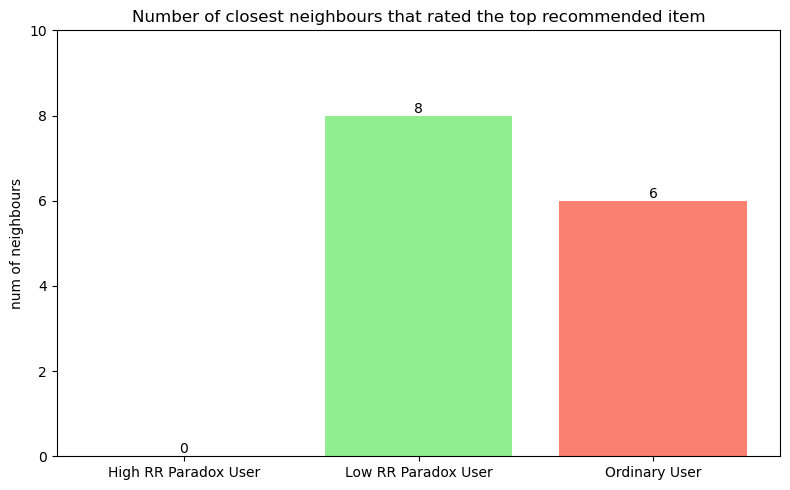

In [387]:
import matplotlib.pyplot as plt

neighbor_rated_recommendation_user = 1.0558910065723009e+20
low_rr_user = 1.1384183606542624e+20  # yes, correct
high_rr_paradox_user = 1.011898710915715e+20# 1.0312203839214251e+20 # yes, correct

users = ['High RR Paradox User', 'Low RR Paradox User', 'Ordinary User']
values = [0, 8, 6]


fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(users, values, color=['skyblue', 'lightgreen', 'salmon'])
ax.set_title('Number of closest neighbours that rated the top recommended item')

ax.set_ylabel('num of neighbours')
ax.set_ylim(0, 10)
# Add the value on top of each bar
ax.bar_label(bars, fmt='%d')

plt.tight_layout()
plt.show()



There is a single users of the three here, whose RR matches the expectation -> High RR  with most of the closest neighbours having rated the top recommended item. 6 out of 10 neighbours have rated that item with the highest rating (5.0). The recommended item is actually rated by 437 users - highly popular with avg rating 4.57.

The Low RR LOw rating guy was recommended the same item as the High RR guy (with 6 neighbours that have rated that item). So again the popularity bias infliuenced the knn prediction for this user

High paradox user  -> only 36 people have rated it. It has average rating of 4.69. But why was it recommended??



## Analysis of Content-based recommender using ablation

In [368]:
import gensim.downloader
from tqdm import tqdm
word2vec_vectors = gensim.downloader.load('word2vec-google-news-300')

In [388]:
item_ids_and_names = [(item, preprocessing(name)) for item, name, _ in item_id_name_and_description]
item_ids_and_descriptions = [(item, preprocessing(description)) for item, _, description in item_id_name_and_description]

### Using only 3 users

In [357]:
ablation_study_users = [high_rr_paradox_user, low_rr_user, neighbor_rated_recommendation_user]

#### Without item name feature

In [361]:
df_item_embeddings = get_embedding_item_representation(item_ids_and_descriptions, word2vec_vectors)
list_items_with_valid_metadata = set(df_item_embeddings.index.tolist())

per_user_recommendation_predictions = {}
per_user_recommendation_predictions_and_sim = {}
for user in tqdm(ablation_study_users):
    user_profile = calculate_user_profile(user, df_train, df_item_embeddings, list_items_with_valid_metadata)
    unrated_user_items = find_unobserved_items_for_user(user, df_train, list_items_with_valid_metadata)
    rec, rec_and_sim = generated_recommendations_for_user(user_profile, unrated_user_items, df_item_embeddings, cutoff=RECOMMENDATION_LIST_CUTOFF)
    per_user_recommendation_predictions[user] = rec
    per_user_recommendation_predictions_and_sim[user] = rec_and_sim    

100%|██████████| 3/3 [00:00<00:00, 129.40it/s]


In [362]:
evaluate_recommendation_performance(per_user_recommendation_predictions, df_train, df_test, k=RECOMMENDATION_LIST_CUTOFF)

Precision@10: 0.067
MAP@10: 0.041
MRR@10: 0.333
Hit Rate top-10: 0.333
Coverage@10: 0.045


#### Without description feature

In [363]:
df_item_embeddings = get_embedding_item_representation(item_ids_and_names, word2vec_vectors)
list_items_with_valid_metadata = set(df_item_embeddings.index.tolist())

per_user_recommendation_predictions = {}
per_user_recommendation_predictions_and_sim = {}
for user in tqdm(ablation_study_users):
    user_profile = calculate_user_profile(user, df_train, df_item_embeddings, list_items_with_valid_metadata)
    unrated_user_items = find_unobserved_items_for_user(user, df_train, list_items_with_valid_metadata)
    rec, rec_and_sim = generated_recommendations_for_user(user_profile, unrated_user_items, df_item_embeddings,  cutoff=RECOMMENDATION_LIST_CUTOFF)
    per_user_recommendation_predictions[user] = rec
    per_user_recommendation_predictions_and_sim[user] = rec_and_sim    

100%|██████████| 3/3 [00:00<00:00, 165.42it/s]


In [364]:
evaluate_recommendation_performance(per_user_recommendation_predictions, df_train, df_test, k=RECOMMENDATION_LIST_CUTOFF)

Precision@10: 0.033
MAP@10: 0.004
MRR@10: 0.042
Hit Rate top-10: 0.333
Coverage@10: 0.045


#### Using all features (name + description)

In [384]:
df_item_name_embeddings = get_embedding_item_representation(item_ids_and_names, word2vec_vectors)
df_item_description_embeddings = get_embedding_item_representation(item_ids_and_descriptions, word2vec_vectors)

df_item_description_embeddings.columns = [df_item_name_embeddings.shape[1]+i for i in range(df_item_description_embeddings.shape[1])]
df_item_embeddings = df_item_name_embeddings.join(df_item_description_embeddings, how='inner')

In [385]:
list_items_with_valid_metadata = set(df_item_embeddings.index.tolist())

per_user_recommendation_predictions = {}
per_user_recommendation_predictions_and_sim = {}
for user in tqdm(ablation_study_users):
    user_profile = calculate_user_profile(user, df_train, df_item_embeddings, list_items_with_valid_metadata)
    unrated_user_items = find_unobserved_items_for_user(user, df_train, list_items_with_valid_metadata)
    rec, rec_and_sim = generated_recommendations_for_user(user_profile, unrated_user_items, df_item_embeddings, cutoff=RECOMMENDATION_LIST_CUTOFF)
    per_user_recommendation_predictions[user] = rec
    per_user_recommendation_predictions_and_sim[user] = rec_and_sim    

100%|██████████| 3/3 [00:00<00:00, 79.00it/s]


In [386]:
evaluate_recommendation_performance(per_user_recommendation_predictions, df_train, df_test, k=RECOMMENDATION_LIST_CUTOFF)

Precision@10: 0.033
MAP@10: 0.006
MRR@10: 0.056
Hit Rate top-10: 0.333
Coverage@10: 0.045


___________________________________

### Using all users

#### Without item name feature

In [370]:
df_item_embeddings = get_embedding_item_representation(item_ids_and_descriptions, word2vec_vectors)
list_items_with_valid_metadata = set(df_item_embeddings.index.tolist())

per_user_recommendation_predictions = {}
per_user_recommendation_predictions_and_sim = {}
for user in tqdm(df_train.user_id.unique()):
    user_profile = calculate_user_profile(user, df_train, df_item_embeddings, list_items_with_valid_metadata)
    unrated_user_items = find_unobserved_items_for_user(user, df_train, list_items_with_valid_metadata)
    rec, rec_and_sim = generated_recommendations_for_user(user_profile, unrated_user_items, df_item_embeddings, cutoff=RECOMMENDATION_LIST_CUTOFF)
    per_user_recommendation_predictions[user] = rec
    per_user_recommendation_predictions_and_sim[user] = rec_and_sim    

100%|██████████| 1105/1105 [00:08<00:00, 126.18it/s]


In [371]:
evaluate_recommendation_performance(per_user_recommendation_predictions, df_train, df_test, k=RECOMMENDATION_LIST_CUTOFF)

Precision@10: 0.030
MAP@10: 0.013
MRR@10: 0.071
Hit Rate top-10: 0.231
Coverage@10: 0.881


#### Without description feature

In [379]:
df_item_embeddings = get_embedding_item_representation(item_ids_and_names, word2vec_vectors)
list_items_with_valid_metadata = set(df_item_embeddings.index.tolist())

per_user_recommendation_predictions = {}
per_user_recommendation_predictions_and_sim = {}
for user in tqdm(df_train.user_id.unique()):
    user_profile = calculate_user_profile(user, df_train, df_item_embeddings, list_items_with_valid_metadata)
    unrated_user_items = find_unobserved_items_for_user(user, df_train, list_items_with_valid_metadata)
    rec, rec_and_sim = generated_recommendations_for_user(user_profile, unrated_user_items, df_item_embeddings,  cutoff=RECOMMENDATION_LIST_CUTOFF)
    per_user_recommendation_predictions[user] = rec
    per_user_recommendation_predictions_and_sim[user] = rec_and_sim    

100%|██████████| 1105/1105 [00:07<00:00, 139.31it/s]


In [380]:
evaluate_recommendation_performance(per_user_recommendation_predictions, df_train, df_test, k=RECOMMENDATION_LIST_CUTOFF)

Precision@10: 0.028
MAP@10: 0.012
MRR@10: 0.070
Hit Rate top-10: 0.210
Coverage@10: 0.883


In [381]:
df_item_name_embeddings = get_embedding_item_representation(item_ids_and_names, word2vec_vectors)
df_item_description_embeddings = get_embedding_item_representation(item_ids_and_descriptions, word2vec_vectors)

df_item_description_embeddings.columns = [df_item_name_embeddings.shape[1]+i for i in range(df_item_description_embeddings.shape[1])]
df_item_embeddings = df_item_name_embeddings.join(df_item_description_embeddings, how='inner')

In [382]:
list_items_with_valid_metadata = set(df_item_embeddings.index.tolist())

per_user_recommendation_predictions = {}
per_user_recommendation_predictions_and_sim = {}
for user in tqdm(df_train.user_id.unique()):
    user_profile = calculate_user_profile(user, df_train, df_item_embeddings, list_items_with_valid_metadata)
    unrated_user_items = find_unobserved_items_for_user(user, df_train, list_items_with_valid_metadata)
    rec, rec_and_sim = generated_recommendations_for_user(user_profile, unrated_user_items, df_item_embeddings, cutoff=RECOMMENDATION_LIST_CUTOFF)
    per_user_recommendation_predictions[user] = rec
    per_user_recommendation_predictions_and_sim[user] = rec_and_sim    

100%|██████████| 1105/1105 [00:10<00:00, 102.41it/s]


In [383]:
evaluate_recommendation_performance(per_user_recommendation_predictions, df_train, df_test, k=RECOMMENDATION_LIST_CUTOFF)

Precision@10: 0.028
MAP@10: 0.013
MRR@10: 0.076
Hit Rate top-10: 0.211
Coverage@10: 0.919


In [33]:
# Reorder the second correlation matrix (tensor)
import torch

# Original correlation tensor
correlation_tensor = torch.tensor([[1.0000, 0.5739, 0.1945, 0.1929, 0.1569],
                                   [0.5739, 1.0000, 0.1915, 0.1408, 0.1625],
                                   [0.1945, 0.1915, 1.0000, 0.1097, 0.0723],
                                   [0.1929, 0.1408, 0.1097, 1.0000, 0.5639],
                                   [0.1569, 0.1625, 0.0723, 0.5639, 1.0000]])

# Convert to numpy for easier manipulation
correlation_matrix_2 = correlation_tensor.numpy()

# Use the same reorder indices from the previous example
# The indices were: [3, 4, 0, 1, 2] which maps:
# Index 0: '0x87227339ff929717:0x3422514fbdbffc0' (was at position 3)
# Index 1: '0x87220cd2b519870f:0x780df887461461f6' (was at position 4)  
# Index 2: '0x87220ad3aaeabf87:0x79d5bcd7ff1266dd' (was at position 0)
# Index 3: '0x872274efda7f0051:0x30146b7f3460f963' (was at position 1)
# Index 4: '0x8722717d2d4eb66d:0x246f16d0e5892e05' (was at position 2)
reorder_indices = [3, 4, 0, 1, 2]

# Reorder both rows and columns of the correlation matrix
reordered_matrix_2 = correlation_matrix_2[np.ix_(reorder_indices, reorder_indices)]

print("Original tensor/matrix:")
print(correlation_tensor)
print("\nReordered matrix:")
print(reordered_matrix_2)
print("\nAs tensor:")
print(torch.from_numpy(reordered_matrix_2))
print("\nReordered item order:")
print(desired_order)


Original tensor/matrix:
tensor([[1.0000, 0.5739, 0.1945, 0.1929, 0.1569],
        [0.5739, 1.0000, 0.1915, 0.1408, 0.1625],
        [0.1945, 0.1915, 1.0000, 0.1097, 0.0723],
        [0.1929, 0.1408, 0.1097, 1.0000, 0.5639],
        [0.1569, 0.1625, 0.0723, 0.5639, 1.0000]])

Reordered matrix:
[[1.     0.5639 0.1929 0.1408 0.1097]
 [0.5639 1.     0.1569 0.1625 0.0723]
 [0.1929 0.1569 1.     0.5739 0.1945]
 [0.1408 0.1625 0.5739 1.     0.1915]
 [0.1097 0.0723 0.1945 0.1915 1.    ]]

As tensor:
tensor([[1.0000, 0.5639, 0.1929, 0.1408, 0.1097],
        [0.5639, 1.0000, 0.1569, 0.1625, 0.0723],
        [0.1929, 0.1569, 1.0000, 0.5739, 0.1945],
        [0.1408, 0.1625, 0.5739, 1.0000, 0.1915],
        [0.1097, 0.0723, 0.1945, 0.1915, 1.0000]])

Reordered item order:
['0x87227339ff929717:0x3422514fbdbffc0', '0x87220cd2b519870f:0x780df887461461f6', '0x87220ad3aaeabf87:0x79d5bcd7ff1266dd', '0x872274efda7f0051:0x30146b7f3460f963', '0x8722717d2d4eb66d:0x246f16d0e5892e05']
